## Empirical Comparisons of the Metropolis-Hastings and Auxilary Gibbs Bayesian Probit Samplers

Mert Tekdemir - mert.tekdemir@studbocconi.it

Bernardo Principi - bernardo.principi@studbocconi.it

Davide Drago - davide.drago@studbocconi.it

In this document two different Bayesian procedures are compared in simulating the posterior distribution of a set of coefficients in a probit regression model. The simulation methods compared are the random walk metropolis algorithm and auxiliary Gibbs algorithm. These procedures are compared using both a simulated dataset and a real dataset and for each dataset across different choices of priors, initializations of the coefficients and parameters for the proposal distributions.


The framework being considered is the classic binary regression setting with a vector $Y$ of $n$ binary variables and a corresponding $n \times p$ covariate matrix of continous and/or categorical data. 

$$ Y = \begin{bmatrix}Y_1 \\ Y_2 \\ \vdots \\ Y_n \end{bmatrix} \text{ and }
X = \begin{bmatrix} 1 & x_{11} & \cdots & x_{1p} \\ 
                    1 & x_{21} & \cdots & x_{2p} \\ 
                    \cdots \\ 
                    1 & x_{n1} & \cdots & x_{np} \end{bmatrix}
$$
$$Y_1,...Y_n \overset{\mathrm{ind.}}{\sim} Bernoulli(\pi_i) $$

By considering a vector $\beta$ of $p$ parameters for the covariates one forms the following linear predictor:

$$ \eta_i = x_i^T\beta $$

Given the probit regression setting the CDF of the standard normal distribution is used as the link function:

$$
\eta_i = \Phi^{-1}(\pi_i) \quad \Rightarrow \quad \pi_i = \Phi(\eta_i)
$$

When using a Bayesian approach a prior is assigned to the vector of parameters $\beta$, $\pi(\beta)$ and all inferences are based on the posterior distribution $\pi(\beta|Y)$. Given that the elements of $Y$ are independent Bernoulli random variables the likelihood is given by:

$$
\mathcal{L} (\beta, Y, X) = \prod_{i = 1}^{n} \pi_i^{y_i} (1-\pi_i)^{1 - y_i} =\prod_{i = 1}^{n} (\Phi(\eta_i))^{y_i} (1-(\Phi(\eta_i))^{1 - y_i}
$$

And so the posterior distribution can be given up to a normalizing constant as the following:

$$ 
\pi(\beta|Y) \propto \pi(\beta) \prod_{i = 1}^{n} (\Phi(\eta_i))^{y_i} (1-(\Phi(\eta_i))^{1 - y_i}
$$

However the expression in analytically intractable and so computational methods must be employed to successfully sample from the posterior distribution. 

## Imports

In [ ]:
import numpy as np
import numpy.linalg

import pandas as pd

from scipy.stats import uniform, norm, multivariate_normal, truncnorm, chi2
from scipy.special import gammaln
import statsmodels.discrete.discrete_model as dm
import statsmodels.regression.linear_model as lr

import tensorflow_probability as tfp
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Auxiliary functions

### Multivariate ESS

These cells contain a series of functions used in calculating the multivariate effective sample size (ESS). 

For a given dependent sample, the ESS aims to calculate the equivalent number of independent samples needed to produce the same amount of information as contained in the dependent samples.

If the ratio between the ESS of the sampling process and the actual sample size of the process is near to one the sample can be considered as good as independent.

After convergence diagnostics are preformed, the ESS of converged chains can be compared to identify which of the chains produces samples that can be considered closer to independent.

Since nearer samples in MCMCs tend to exhibit higher autocorrelation than further samples it is common to select a cycle size $n$ such that a sample from the Markov chain is used every $k$ steps. By splitting a single long Markov chain across different candidate choices for $k$ one effectivley creates different chains that can be compares using the ESS to actual sample size ratio. Through this comparison one should look to select the smallest possible candidate $k$ that produces a chain with an ESS near 1.

When it comes to estimating the ESS one can either use a univarite or multivariate estimator. A univariate ESS will provide an effective sample size for each parameter separately, and conservative methods dictate, to consider the smallest estimate. This method ignores all cross-correlations across components. The multivariate ESS returns one number for the effective sample size of each parameter and it does so by accounting for all the cross-correlations in the process. 

The code below is used to calculate the multivariate ESS:

$$ mESS = 𝑛 \left( \frac{|(\Lambda)|}{|\Sigma|} \right) ^ {\frac{1}{𝑝}}. $$

Where:

$\Lambda$ is the covariance structure of the posterior (also the asymptotic covariance in the CLT if you had independent samples)

$\Sigma$ is the asymptotic covariance matrix in the Markov chain CLT (different from Λ since samples are correlated).

$p$ is number of quantities being estimated (or in this case, the dimension of the posterior).

$|⋅|$ is the determinant.

$n$ is the sample size

mESS can be estimated by using the sample covariance matrix to estimate $\Lambda$ and the batch means covariance matrix to estimate $\Sigma$.

In [ ]:
def fminESS(p, alpha=.05, eps=.05, ess=None):
    """
    Minimum effective sample size
    """

    crit = chi2.ppf(1 - alpha, p)
    foo = 2. / p

    if ess is None:
        logminESS = foo * np.log(2.) + np.log(np.pi) - foo * np.log(p) -\
            foo * gammaln(p / 2.) - 2. * np.log(eps) + np.log(crit)
        return np.round(np.exp(logminESS))
    else:
        if isinstance(ess, str):
            raise ValueError("Only numeric entry allowed for ess")
        logEPS = .5 * foo * np.log(2.) + .5 * np.log(np.pi) -\
            .5 * foo * np.log(p) - .5 * foo * gammaln(p / 2.) -\
            .5 * np.log(ess) + .5 * np.log(crit)
        return np.exp(logEPS)


def multiESS(X, b='sqroot', Noffsets=10, Nb=None):
    """
    Compute multivariate effective sample size of a single Markov chain X,
    using the multivariate dependence structure of the process.
    X: MCMC samples of shape (n, p)
    n: number of samples
    p: number of parameters
    b: specifies the batch size for estimation of the covariance matrix in
       Markov chain CLT. It can take a numeric value between 1 and n/2, or a
       char value between:
    'sqroot'    b=floor(n^(1/2)) (for chains with slow mixing time; default)
    'cuberoot'  b=floor(n^(1/3)) (for chains with fast mixing time)
    'lESS'      pick the b that produces the lowest effective sample size
                for a number of b ranging from n^(1/4) to n/max(20,p); this
                is a conservative choice
    If n is not divisible by b Sigma is recomputed for up to Noffsets subsets
    of the data with different offsets, and the output mESS is the average over
    the effective sample sizes obtained for different offsets.
    Nb specifies the number of values of b to test when b='less'
    (default NB=200). This option is unused for other choices of b.
    """

    # MCMC samples and parameters
    n, p = X.shape

    if p > n:
        raise ValueError(
            "More dimensions than data points, cannot compute effective "
            "sample size.")

    # Input check for batch size B
    if isinstance(b, str):
        if b not in ['sqroot', 'cuberoot', 'less']:
            raise ValueError(
                "Unknown string for batch size. Allowed arguments are "
                "'sqroot', 'cuberoot' and 'lESS'.")
        if b != 'less' and Nb is not None:
            raise Warning(
                "Nonempty parameter NB will be ignored (NB is used "
                "only with 'lESS' batch size B).")
    else:
        if not 1. < b < (n / 2):
            raise ValueError(
                "The batch size B needs to be between 1 and N/2.")

    # Compute multiESS for the chain
    mESS = multiESS_chain(X, n, p, b, Noffsets, Nb)

    return mESS


def multiESS_chain(Xi, n, p, b, Noffsets, Nb):
    """
    Compute multiESS for a MCMC chain.
    """

    if b == 'sqroot':
        b = [int(np.floor(n ** (1. / 2)))]
    elif b == 'cuberoot':
        b = [int(np.floor(n ** (1. / 3)))]
    elif b == 'less':
        b_min = np.floor(n ** (1. / 4))
        b_max = max(np.floor(n / max(p, 20)), np.floor(np.sqrt(n)))
        if Nb is None:
            Nb = 200
        # Try NB log-spaced values of B from B_MIN to B_MAX
        b = set(map(int, np.round(np.exp(
            np.linspace(np.log(b_min), np.log(b_max), Nb)))))

    # Sample mean
    theta = np.mean(Xi, axis=0)
    # Determinant of sample covariance matrix
    if p == 1:
        detLambda = np.cov(Xi.T)
    else:
        detLambda = np.linalg.det(np.cov(Xi.T))

    # Compute mESS
    mESS_i = []
    for bi in b:
        mESS_i.append(multiESS_batch(Xi, n, p, theta, detLambda, bi, Noffsets))
    # Return lowest mESS
    mESS = np.min(mESS_i)

    return mESS


def multiESS_batch(Xi, n, p, theta, detLambda, b, Noffsets):
    """
    Compute multiESS for a given batch size B.
    """

    # Compute batch estimator for SIGMA
    a = int(np.floor(n / b))
    Sigma = np.zeros((p, p))
    offsets = np.sort(list(set(map(int, np.round(
        np.linspace(0, n - np.dot(a, b), Noffsets))))))

    for j in offsets:
        # Swapped a, b in reshape compared to the original code.
        Y = Xi[j + np.arange(a * b), :].reshape((a, b, p))
        Ybar = np.squeeze(np.mean(Y, axis=1))
        Z = Ybar - theta
        for i in range(a):
            if p == 1:
                Sigma += Z[i] ** 2
            else:
                Sigma += Z[i][np.newaxis, :].T * Z[i]

    Sigma = (Sigma * b) / (a - 1) / len(offsets)
    mESS = n * (detLambda / np.linalg.det(Sigma)) ** (1. / p)

    return mESS

Compute and plot the multivariate ESS of a markov chain for different choices of the cycle size $k$

In [ ]:
#def compute_optimal_step(b, max_step=50):
#  results = []
#  for i in range(1,max_step):
#    ess = tfp.mcmc.effective_sample_size(np.stack(b)[::i,:])
#    results.append(np.min(ess.numpy()) / len(b[::i]))
#  return results
#
#def plot_steps(results):
#  plt.plot(results)
#  plt.title('% of information as if from i.i.d. sample')
#  plt.xlabel('Step size')
#  plt.ylabel('% of information')

def compute_optimal_step(b, max_step=20):
  """
  Given a MCMC for a sigle parameter compute the
  multivariate ESS at that chain for every cycle size
  between 1 and maxstep-1

  b: an nx1 cahin of sample values for a parameter
  max step: the maximum cycle size to consider 
  """
  results = []
  for i in range(1,max_step):
    multi_ess = multiESS(b[::i,:], 'less')
    results.append(multi_ess / len(b[::i]))
  return results

def plot_steps(results):
  """
  Plot the output from compute_optimal_step function

  results: output from compute_optimal_step function
  """
  plt.figure()
  plt.plot(results)
  plt.title('ESS-Actual Sample Size Ratio')
  plt.xlabel('Step size')
  plt.ylabel('ESS-ASS ratio')
  plt.show()

### Diagnostic Functions

#### Estimated Standard Error Functions

A second goal is estimation of posterior expectations. Suppose that the expectation of interest is $\mathbb{E}[g(\beta_k)]$. From the simulated sample, this posterior expectation can be estimated by either the sample mean of $g(\beta_k)$ or, through the law of iterated expectation, the sample mean of ${\mathbb{E}[g(\beta_k)|{ \beta_r^{(i)} \text{, } r \neq k}]}$. In either case it will be of interest to compute a simulation standard error for the sample mean estimate. To compute this standard error from this correlated simulation sample, we apply the well-known batch means method (see, for example, Bratley, Fox, and Schrage 1987). We batch or section the sample into subsamples of equal size. When the lag one autocorrelation of the batch means is under .05, the simulation standard error is computed as the standard deviation of the batch means divided by the square root of the number of batches

In [ ]:
def create_batches(b, batch_size=100):
  """
  Given a MCMC of p parameter split the MCMC
  into p len(b)/batch_size batches where each batch
  contains batch_size number of observations from the
  chain. 

  Note: If len(b)/batch_size is not divisible with remainder
  zero the necessary number of samples from the start of
  the chain are removed in order to create equal size batches.
  

  b: An n x p cahin of sample values for a parameter
  batch_size: The desired number of samples per batch

  output: A (len(b)/batch_size) x batch_size x p matrix
  """
  #Number of batches resulting from batch size
  n_batches = len(b)//batch_size

  #Initalize output array
  subsamples = np.zeros((n_batches, batch_size, b.shape[1]))

  #Slice the input array to create equal sized subsamples
  b_for_subsamples = b[len(b)%batch_size:]

  #For each subsample take from the input chain
  for i in range(n_batches):
    subsamples[i] = b_for_subsamples[i::n_batches]

  return subsamples



In [ ]:
# This gets autocorrs for each coefficient in each batch (20x3), only with lag 1 (as written in the paper), why?
# Because we want to see what is valid, make the avg, and use it to estimate the sd

def compute_coefficients_std(subsamples, threshold=0.1):
  """
  Takes a 3 dimensional matrix of shape m x n x p where
  m is the number of subsamples of a Markov chain, n is
  the number of observations from the Markov chain
  per subsample and p is the number of parameters.
  Computes the standard deviation of the parameters
  using the batch means method.
  """

  #Initalize a vector to store autocorrelations at lag 1 per subsample
  auto = np.zeros((subsamples.shape[0], subsamples.shape[2]))

  #Loop over parameter per subsample
  for i in range(subsamples.shape[0]):
    for j in range(subsamples.shape[2]):
      #store autocorrelation at lag one 
      auto[i, j] = np.corrcoef(subsamples[i,:,j][1:], subsamples[i,:,j][:-1])[0,1]
  
  #The number of valid subsamples for computing the standard deviation
  #Must have maximum autocorrelatioon at lag one less than threshold
  valid_subsamples = subsamples[np.max(np.abs(auto), axis = 1) < threshold]  

  #If not enough subsamples are available try with a larger threshold
  if len(valid_subsamples) <= 1:
    print(f"No valid subsamples have been found, retrying with threshold = {round(threshold + 0.1, 2)}")
    return compute_coefficients_std(subsamples, threshold=threshold+0.1)
  
  return np.mean(np.std(valid_subsamples, axis=1), axis=0) # Get std for each coefficient in each subsample (11x3), then calculated the mean of std over subsamples (so for each coeff)

#### Plot trace plots, autocorrelation, densities and acceptance rates

A collection of functions to plot diagnostics for a given MCMC chain

In [ ]:
def plot_trace(b, lag_sum=50):
  """
  Given a MCMC for a sigle parameter plot the
  trace plot of the samples and the corresponding
  moving sample average

  b: an nx1 cahin of sample values for a parameter
  lag_sum: the maximum number of lagged observations
  to consider in the moving average
  """
  if not isinstance(b, np.ndarray):
    b = np.array(b)
    
  b_avg = np.zeros(len(b))
  for i in range(len(b)):
      b_avg[i] = np.mean(b[max(0, i-lag_sum): i+1])

  plt.plot(b, label='Resulting MC')
  plt.plot(b_avg, label=f'Moving average of the last {lag_sum} values')
  plt.title('Resulting MC')
  plt.legend(loc=3)
  plt.xlabel("Iteration")
  plt.ylabel("Values")

def plot_autocorr(b, len_corr=100):
  """
  Given a MCMC for a sigle parameter plot the
  autocorrelation function for size len_corr

  b: an nx1 cahin of sample values for a parameter
  len_corr: the maximum number of lagged observations
  to consider in the autocorrelation function
  """
  #Check for valid len_corr
  while len(b) < len_corr + 5:
    len_corr = len(b) - 5
  
  auto_corr = np.zeros(len_corr)
  corr_min = np.zeros(len_corr)
  corr_max = np.zeros(len_corr)
  for i in np.arange(len_corr):
      corr_i = np.corrcoef(b[(i+1):], b[:(len(b)-i-1)])[0,1]
      auto_corr[i] = corr_i
      if corr_i > 0:
          corr_max[i] = corr_i
      elif corr_i < 0:
          corr_min[i] = corr_i
    
  plt.vlines([i for i in range(1, len_corr+1)], ymin=corr_min, ymax=corr_max, color="red", linewidth=1)
  plt.ylim((-0.3,0.3))
  plt.title('Autocorrelation')
  plt.xlabel("Lag")
  plt.ylabel("Correlation")

def plot_densities(b, n_kdes=3, legend=True):
  """
  Given a MCMC for a sigle parameter plot the
  kernal density plots resulting from the samples
  at different batches of the MCMC

  b: an nx1 cahin of sample values for a parameter
  n_kdes: the number of kde plots to be plotted
  by paritioning the MCMC intoo n_kdes batches
  """
  
  #Split the MCMC into n_kde batches
  batches = np.array_split(b, n_kdes)
  i=0
  for batch in batches:
    sns.kdeplot(batch, label=f'batch {i}')
    i+=1

  #plot the entire MCMC distribution
  sns.kdeplot(b[:], label='Distribution of the MC')

  if legend:
    plt.legend(loc=3)

  plt.title('Distribution of the MC')

def plot_acc_rate(acc, acc_obs=200):
  """
  Given an nx1 binary that codes if a candidate
  was accepted by the metreopolis algorithim at
  given step, this function plots the moving average
  of the acceptance rate

  acc: an nx1 binary array
  acc_obs: the number of lagged observations to 
  consider in the moving average
  """
  acc_rates = np.zeros(len(acc))
  for i in range(len(acc)):
      acc_rates[i] = np.mean(acc[max(0, i-acc_obs): i+1])
  
  plt.plot(acc_rates)
  plt.title('Acceptance rates')

def plot_diagnostics(b, acc=None, lag_sum=50, len_corr=100, acc_obs=200, n_kdes=3, title=None, fontsize_title=18):
  """
  A master function that plots all diagnostic tests included above
  """
  if acc is None:
    plt.figure(figsize=(17,4))
    plt.subplot(131)
    plot_trace(b, lag_sum)
    plt.subplot(132)
    plot_autocorr(b, len_corr)
    plt.subplot(133)
    plot_densities(b, n_kdes)
  
  else:
    plt.figure(figsize=(22,4))
    plt.subplot(141)
    plot_trace(b, lag_sum)
    plt.subplot(142)
    plot_autocorr(b, len_corr)
    plt.subplot(143)
    plot_densities(b, n_kdes)
    plt.subplot(144)
    plot_acc_rate(acc, acc_obs)

  if not (title is None):
    plt.suptitle(title+'\n\n', fontsize=fontsize_title)
    plt.subplots_adjust(top=0.85)
  
  plt.show()

## Implementation of the Metropolis Algorithm

Metropolis-Hastings algorithms are a family of Markov chain Monte Carlo methods for perfect sampling from a possibly multivariate target posterior distribution. Given an initialized value for the parameter vector $\beta_0$ and a conditional density $q(\beta | \cdot)$ called a proposal density, at iteration $t+1$ a new sample $\beta_{t+1}$ is added to the chain using $\beta_t$ as follows:


1.   Draw a candidate sample $\beta^*$ from $q(\beta|\beta_t)$
2.   Draw $U$ from a uniform(0,1)
3.   Solve $\alpha(\beta_t, \beta^*) = min \left (1, \frac{\pi(\beta^*|Y)}{\pi(\beta_t|Y)}\frac{q(\beta_t|\beta^*)}{q(\beta^*|\beta_t)}\right)$
4.   Set $\beta_{t+1} = \beta^*$ if $U \leq \alpha(\beta_t, \beta^*)$
5.   Otherwise set $\beta_{t+1} = \beta_t$ 


For the framework being considered take as the proposal distribution the multivariate normal centered at $\beta_t$ with co-variance matrix given by the inverse of the Fischer information matrix evaluated at $\beta_t$

$$ q(\beta^*|\beta_t) = N(\beta_t \text{,} \tau V) $$
$$ V = (-\ell^{''}(\beta_t))^{-1} = \mathbb{I}(\beta_t)^{-1} $$

The Fischer information can be calculated from the data as follows:

$$
\mathbb{I}(\beta_t) = \left(X^TW_{t}X\right)
$$

Where $W$ is an $n \times n$ diagonal matrix such that:

$$
W_{ii} = \text{Var}(Y_i)^{-1} \left(\frac{\partial \eta_i}{\partial \mu_i} \right)^{-2}
$$

Recall that $Y_i$ has the Bernoulli distribution with parameter $\pi_i$ so that:

$$
\text{Var}(Y_i) = \pi_i(1-\pi_i) = \mu_i(1-\mu_i)
$$

Also recall that $\eta_i$ is the CDF of the standard normal distribution so that:

$$
\frac{\partial \eta_i}{\partial \mu_i} = \dfrac{1}{\phi(\eta_i)}.
$$

And so the the matrix $W$ simplifies to:
$$
W_{ii} = \dfrac{1}{\mu_i(1-\mu_i)} \phi(\eta_i)^2
$$

Finally, notice that by symmetry of the proposal distribution the acceptance probability $\alpha$ simplifies t:

$$\alpha(\beta_t, \beta^*) = min \left (1, \frac{\pi(\beta^*|Y)}{\pi(\beta_t|Y)} \right)$$

Therefore the candidate that increases the posterior distribution is always accepted.

In [ ]:
def Variance(X, b, threshold=5):
  """
  Given an Bernoulli dependent variable calculate the
  Fischer information matrix evaluated at beta at iteration t
  using the matrix of covariates, the vector of parameters beta,
  and the variance property of a bernoulli random variable

  X: n x p matrix of covariates
  b: vector of paramters from iteration t of the MCMC
  threshold: A threshold value for eta to avoid division
  by zero in the calculation of the matrix W and inversion of
  the Fischer matrix

  Outputs the inverse Fischer information evaluated at iteration
  t of the MCMC
  """
  eta = np.matmul(X, b)

  #If eta is too large or too small the cdf will approximate to zero
  if (eta>threshold).any():
    eta[eta>threshold] = threshold
  if (eta<-threshold).any():
    eta[eta<-threshold] = -threshold
  mu = norm.cdf(eta)
  W = np.diag( ((1/(mu*(1-mu))) * ((norm.pdf(eta))**2)).reshape(X.shape[0],) )
  Fisher_matrix = np.linalg.multi_dot([X.T, W, X])
  return np.linalg.inv(Fisher_matrix)

The posterior distribution can be given up to a normalizing constant at each iteration t as follows:

$$ 
\pi(\beta_t|Y) \propto \pi(\beta_t) \prod_{i = 1}^{n} (\Phi(\eta_i))^{y_i} (1-(\Phi(\eta_i))^{1 - y_i}
$$


In [ ]:
def posterior(prior, X, Y, b):
  """
  Given a prior distribution calculate the posterior
  at iteration t using the likelihood of the Bernoulli
  dependent variable

  prior: Either a scipy distribution object or an
  improper (constant) prior. Improper non-constant
  priors are not supported

  X: n x p matrix of covariates
  Y: n x 1 vector of binary dependent variables
  b: 1 x p vector of parameter samples

  Outputs the pdf of the posterior distribution
  evaluated at the current iteration of beta given 
  the dependent variables
  """

  #If a constant improper prior is passed the constant is kept
  #Otherwise compute the pdf
  if not isinstance(prior, int):
    prior = prior.pdf(b)

  likelihood = np.prod([norm.cdf(np.dot(X[i], b)) if Y[i]==1 else (1-norm.cdf(np.dot(X[i], b))) for i in range(X.shape[0])])
  return prior*likelihood

In [ ]:
def Metropolis(X, Y, beta0, tau=0.4, prior=None, T=100, threshold=5):
  """
  Master function for running the metropolis algorithim

  X: An n x p matrix of covariates
  Y: An n x 1 vector of binary dependent variables
  beta0: An initalized 1 x p vector of parameters
  prior: The prior distribution assigned to the parameters
  if None then a multivariate normal is used centered at the
  zero with the covariance matrix the identity matrix. Any
  scipy distribution object or constant improper prior may be passed
  T: Number of iterations to run the MCMC
  Threshold: A threshold value for the linear predictor. 
  The threshold is applied both to the lower and upper bound

  Outputs a T+1 x p MCMC where each row consists of p values
  that are sampled from the posterior distribution of the 
  parameters of interest. The zeroth row corresponds to the
  initalized value of the parameters beta0

  Outpus a T x 1 binary vector corresponding to if a candidate
  value at iteration t was accepted (1) or rejected (0)
  """

  #Default prior
  if prior is None:
    prior=multivariate_normal(np.zeros(len(beta0)), len(beta0)*np.eye(len(beta0)))

  #Initalize betas output
  betas = np.zeros((T+1,len(beta0)))

  #Initalize acceptence vector
  accepted = np.zeros(T)

  #Beta used at first iteration is the initalized one
  beta_t = beta0.copy()

  #Store the initalized betas as value 0 in the chain
  betas[0] = beta0.copy()

  #Run the metropolis procedure T times
  for i in range(T):
    V = Variance(X, beta_t, threshold=threshold)

    candidate = np.random.multivariate_normal(beta_t, tau*V)

    u = np.random.uniform()
    
    posterior_ratio = posterior(prior, X, Y, candidate) / posterior(prior, X, Y, beta_t)
    
    alpha = min(1, posterior_ratio)

    if alpha > u:
      betas[i+1] = candidate.copy()
      beta_t = candidate.copy()
      accepted[i] = 1

    else:
      betas[i+1] = beta_t.copy()

  return betas, accepted

## Implementation of the Auxiliary Gibbs Sampling Algorithm

In [ ]:
def draw_new_zeta(b, X, Y):
  """
  Given an 1 x p vector of sampled parameters
  and the data draw a new cadidate auxiallary variable
  as defined in the auxillary gibbs algorithim

  b: a 1 x p vector of sample parameters
  X: An n x p matrix of covariates
  Y: a n x 1 vector of binary dependent variables

  outputs a 1 x n vecotr of new cadidate values
  for the auxillary variables
  """
  #Initalize new variables to zero
  new_Z = np.zeros(len(Y))

  #Update the auxially variables
  for i in range(len(Y)):
    eta = np.dot(X[i].T, b)

    #If Y=1 draw from the normal centered at eta truncated at the left at zero
    if Y[i] == 1:

      #If the value of eta is too large the candidate new Z is approximated to zero
      try:
        new_Z[i] = truncnorm.rvs(a=-eta, b=np.inf, loc=eta)
      except:
        print('Location parameter of the truncnorm is too small, auxillary variable Z approximated to zero')
        new_Z[i] = 0

    #If Y=0 draw from the normal centered at eta truncated at the right at zero
    elif Y[i] == 0:

      #If the value of eta is too large the candidate new Z is approximated to zero
      try:
        new_Z[i] = truncnorm.rvs(a=-np.inf, b=-eta, loc=eta)
      except:
        print('Location parameter of the truncnorm is too large, auxillary variable Z approximated to zero')
        new_Z[i] = 0

  return new_Z

def draw_new_beta(Z, X, Y, informative_prior=False):
  """
  Generate a 1 x p candidate new parameter vector
  for iteration t of the MCMC using the Auxillary
  gibbs sampler

  Z: a 1 x n vector of auxillary variables
  X: An n x p matrix of covariates
  Y: a n x 1 vector of binary dependent variables
  informative_prior: Either a (b0, V0) tuple where 
  the first element represents the mean of a multivariate 
  normal distribution and the second one its covariance
  matrix or False to use a noninformative prior
  
  outputs a 1 x p vector of new parameter values
  for the iteration t of the MCMC  
  """
    
  #parameters for the posterior distribution given an informative prior
  if not informative_prior:
    cov_beta = np.linalg.inv(np.matmul(X.T, X))
    mean_beta = np.linalg.multi_dot([cov_beta, X.T, Z])    
    new_beta = np.random.multivariate_normal(mean_beta, cov_beta)

  #parameters for the posterior distribution given an informative prior
  else:
    b0 = informative_prior[0]
    V0 = informative_prior[1]

    cov_beta = np.linalg.inv(np.linalg.inv(V0) + np.matmul(X.T, X))
    mean_beta = np.matmul(cov_beta, np.matmul(np.linalg.inv(V0), b0) + np.matmul(X.T, Z))
    new_beta = np.random.multivariate_normal(mean_beta, cov_beta)
  
  return new_beta

In [ ]:
def Auxiliary_Gibbs(X, Y, beta0, T=100, informative_prior=False):
  """
  Master function for running the auxillary gibbs
  sampling procedure.

  X: an n x p matrix of covariates
  Y: an n x 1 vector of bianry dependent variables
  beta0: a p x 1 vector of initalized parameter values
  informative_prior: Either True or False and 
  determines how to specify the parameters
  of the posterior law

  Outputs a T+1 x p MCMC where each row consists of p values
  that are sampled from the posterior distribution of the 
  parameters of interest. The zeroth row corresponds to the
  initalized value of the parameters beta0
  """
  #Initalize output vector
  betas = np.zeros((T+1,len(beta0)))

  #Store the initalized betas as value 0 in the chain
  betas[0] = beta0.copy()

  #Beta used at first iteration is the initalized one
  beta_t = beta0.copy()

  #Run the auxillalry gibbs sampling procedure
  for i in range(1, T+1):
    Z = draw_new_zeta(beta_t, X, Y)
    beta_t = draw_new_beta(Z, X, Y, informative_prior)
    betas[i] = beta_t.copy()

  return betas

## Functions to run the samplers

### Sample MCMC using Metropolis Sampler Algorithm

In [ ]:
def run_metropolis(X, Y, starting_beta, T=100, prior=None, tau=0.4, threshold=5, zoom_in=None, burnin=None, max_step_ess=30, max_step=None, batch_size=100, threshold_autocorr=0.05, sig_lvl=0.05, n_kdes=5):
  beta_chain_metr, acc_metr = Metropolis(X, Y, starting_beta, T=T, prior=prior, tau=tau, threshold=threshold)

  for beta in range(beta_chain_metr.shape[1]):
    title = f'Trace Plots and Diagnostics for Coefficient {beta}'
    plot_diagnostics(beta_chain_metr[:zoom_in,beta], acc_metr[:zoom_in], n_kdes=n_kdes, title=title, fontsize_title=16)
  print()
  print()
  if burnin is None:
    burnin = int(input('Insert the desired burnin rate: '))
  clear_output()

  beta_chain_metr, acc_metr = beta_chain_metr[burnin:], acc_metr[burnin:]
  results_steps_metr = compute_optimal_step(beta_chain_metr, max_step=max_step_ess)

  if max_step is None:
    plot_steps(results_steps_metr)
    print()
    print()
    max_step = int(input('Insert the maximum acceptable step size: '))
    clear_output()

  best_step = np.argmax(results_steps_metr[:max_step]) + 1
  beta_chain_metr_step = beta_chain_metr[::best_step]

  print(f'Chosen burn-in period  for the MCMC:\t\t{burnin}')
  print(f'Chosen step size to obtain i.i.d. samples:\t{best_step}')
  print(f'Significance level for testing the estimates:\t{sig_lvl}')
  if beta_chain_metr_step.shape[0] < 105:
    print(f'Maximum lag considered for autocorrelations:\t{beta_chain_metr_step.shape[0] - 5}')
  print()

  subsamples_metr = create_batches(beta_chain_metr, batch_size=batch_size)

  means = np.mean(beta_chain_metr, axis=0).round(5)
  ses = compute_coefficients_std(subsamples_metr, threshold=threshold_autocorr).round(5)
  conf_ints = (means.reshape(-1,1) + np.hstack((-1*norm.ppf(1-sig_lvl/2)*ses.reshape(-1,1), norm.ppf(1-sig_lvl/2)*ses.reshape(-1,1)))).round(5)

  print()
  for beta in range(beta_chain_metr.shape[1]):
    print(f'Coefficient {beta}:\tEstiamted parameter: {means[beta]}', 
          f'\tEstimated standard error: {ses[beta]}',
          f'\tEstimated confidence interval: {conf_ints[beta]}'
          f'\tSignificant: {"Yes" if np.prod(conf_ints[beta])>0 else "No"}')
  print()

  for beta in range(beta_chain_metr_step.shape[1]):
    title = f'Trace Plots and Diagnostics for Coefficient {beta}'
    plot_diagnostics(beta_chain_metr_step[:,beta], acc_metr, n_kdes=n_kdes, title=title, fontsize_title=16)

  return np.stack((means, ses)).T

### Sample MCMC using Auxiliary Gibbs Sampler Algorithm

In [ ]:
def run_aux_gibbs(X, Y, starting_beta, T=500, informative_prior=False, zoom_in=None, burnin=None, max_step_ess=50, max_step=None, batch_size=100, threshold_autocorr=0.05, sig_lvl=0.05, n_kdes=5):
  beta_chain_gibb = Auxiliary_Gibbs(X, Y, starting_beta, T=T, informative_prior=informative_prior)

  for beta in range(beta_chain_gibb.shape[1]):
    title = f'Trace Plots and Diagnostics for Coefficient {beta}'
    plot_diagnostics(beta_chain_gibb[:zoom_in,beta], n_kdes=n_kdes, title=title, fontsize_title=16)
  print()
  print()
  if burnin is None:
    burnin = int(input('Insert the desired burnin rate: '))
  clear_output()

  beta_chain_gibb = beta_chain_gibb[burnin:]
  results_steps_gibb = compute_optimal_step(beta_chain_gibb, max_step=max_step_ess)

  if max_step is None:
    plot_steps(results_steps_gibb)
    print()
    print()
    max_step = int(input('Insert the maximum acceptable step size: '))
    clear_output()

  best_step = np.argmax(results_steps_gibb[:max_step]) + 1
  beta_chain_gibb_step = beta_chain_gibb[::best_step]

  print(f'Chosen burn-in period  for the MCMC:\t\t{burnin}')
  print(f'Chosen step size to obtain i.i.d. samples:\t{best_step}')
  print(f'Significance level for testing the estimates:\t{sig_lvl}')
  if beta_chain_gibb_step.shape[0] < 105:
    print(f'Maximum lag considered for autocorrelations:\t{beta_chain_gibb_step.shape[0] - 5}')
  print()

  subsamples_gibb = create_batches(beta_chain_gibb, batch_size=batch_size)

  means = np.mean(beta_chain_gibb, axis=0).round(5)
  ses = compute_coefficients_std(subsamples_gibb, threshold=threshold_autocorr).round(5)
  conf_ints = (means.reshape(-1,1) + np.hstack((-1*norm.ppf(1-sig_lvl/2)*ses.reshape(-1,1), norm.ppf(1-sig_lvl/2)*ses.reshape(-1,1)))).round(5)

  print()
  for beta in range(beta_chain_gibb.shape[1]):
    print(f'Coefficient {beta}:\tEstiamted parameter: {means[beta]}', 
          f'\tEstimated standard error: {ses[beta]}',
          f'\tEstimated confidence interval: {conf_ints[beta]}'
          f'\tSignificant: {"Yes" if np.prod(conf_ints[beta])>0 else "No"}')
  print()

  for beta in range(beta_chain_gibb_step.shape[1]):
    title = f'Trace Plots and Diagnostics for Coefficient {beta}'
    plot_diagnostics(beta_chain_gibb_step[:,beta], n_kdes=n_kdes, title=title, fontsize_title=16)

  return np.stack((means, ses)).T

## Testing purposes

### Simulated Data

#### Simulating some random data

In [ ]:
#generate the data
n = 100
p = 2    #number of covariates, excluding the intercept
beta_true = np.array([2,-5,1]).reshape((3,1))   #true coefficients
sigma_true = 2.5    #true standard deviation

X_sim = np.random.normal(size = (n,p))   #random covariates
X_sim = np.hstack((np.ones((n,1)), X_sim))   #add the intercept
Y_sim = np.matmul(X_sim, beta_true) + np.random.normal(size=n, loc=0, scale=sigma_true).reshape((n,1))   #generate Y

Y_sim = (Y_sim > 2).reshape(1, -1)[0] * 1

In [ ]:
#Probit model with MLE
probit_model = dm.Probit(Y_sim, X_sim)
probit_sim_results = probit_model.fit()
print(probit_sim_results.summary())

Optimization terminated successfully.
         Current function value: 0.273249
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                         Probit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Fri, 07 Jan 2022   Pseudo R-squ.:                  0.6053
Time:                        20:44:23   Log-Likelihood:                -27.325
converged:                       True   LL-Null:                       -69.235
Covariance Type:            nonrobust   LLR p-value:                 6.292e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1682      0.200     -0.842      0.400      -0.560       0.223
x1            -2.6167      0.

In [ ]:
# Assign priors, taus and initial betas to test the model on different configurations

initial_beta_sim_uni = np.random.uniform(low=-10, high=10, size=X_sim.shape[1])
initial_beta_sim_norm = np.random.normal(0, scale=5, size=X_sim.shape[1])
initial_beta_sim_probit = probit_sim_results.params

# Actual parameters that will be tested
parameters_combinations_sim_metr = [{'b0':initial_beta_sim_norm, 'prior':multivariate_normal(initial_beta_sim_norm*np.ones(X_sim.shape[1]), np.eye(X_sim.shape[1])), 'tau':0.45}, 
                                    {'b0':initial_beta_sim_norm, 'prior':1, 'tau':0.45}, 
                                    {'b0':initial_beta_sim_probit, 'prior':1, 'tau':0.45},
                                    {'b0':initial_beta_sim_probit, 'prior':multivariate_normal(initial_beta_sim_probit*np.ones(X_sim.shape[1]), np.eye(X_sim.shape[1])), 'tau':0.45}, 
                                    {'b0':initial_beta_sim_probit, 'prior':multivariate_normal(initial_beta_sim_probit*np.ones(X_sim.shape[1]), 5*np.eye(X_sim.shape[1])), 'tau':0.45},
                                    {'b0':initial_beta_sim_probit, 'prior':multivariate_normal(initial_beta_sim_probit*np.ones(X_sim.shape[1]), np.eye(X_sim.shape[1])), 'tau':0.30}]

parameters_combinations_sim_gibb = [{'b0':initial_beta_sim_norm, 'prior':(initial_beta_sim_norm, np.eye(X_sim.shape[1]))}, 
                                    {'b0':initial_beta_sim_norm, 'prior':False}, 
                                    {'b0':initial_beta_sim_probit, 'prior':False}, 
                                    {'b0':initial_beta_sim_probit, 'prior':(initial_beta_sim_probit, 5*np.eye(X_sim.shape[1]))}]

#### Metropolis Sampler

Chosen burn-in period  for the MCMC:		300
Chosen step size to obtain i.i.d. samples:	17
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -0.01267 	Estimated standard error: 0.17073 	Estimated confidence interval: [-0.34729  0.32195]	Significant: No
Coefficient 1:	Estiamted parameter: -1.63014 	Estimated standard error: 0.27501 	Estimated confidence interval: [-2.16915 -1.09113]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.7443 	Estimated standard error: 0.21043 	Estimated confidence interval: [0.33186 1.15674]	Significant: Yes



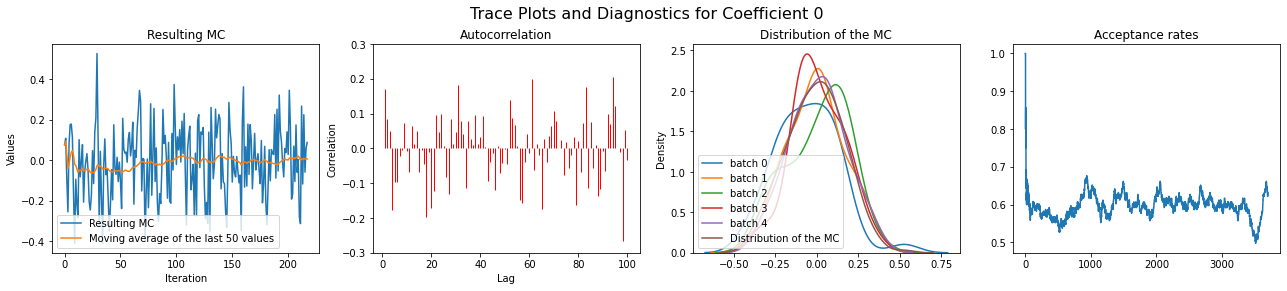

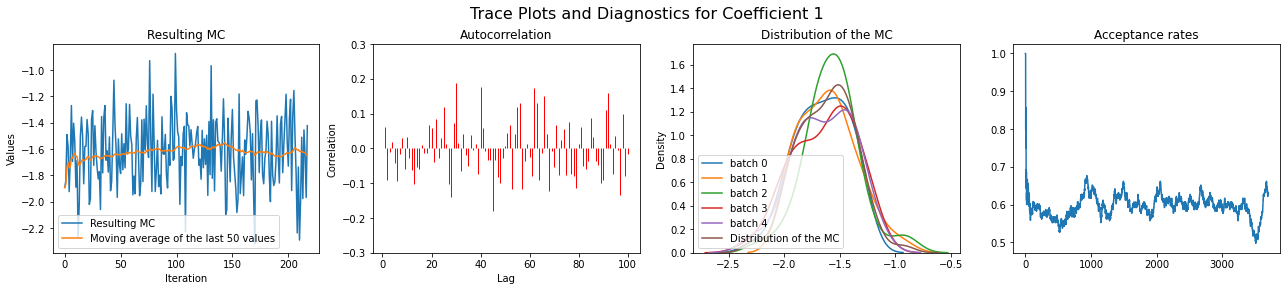

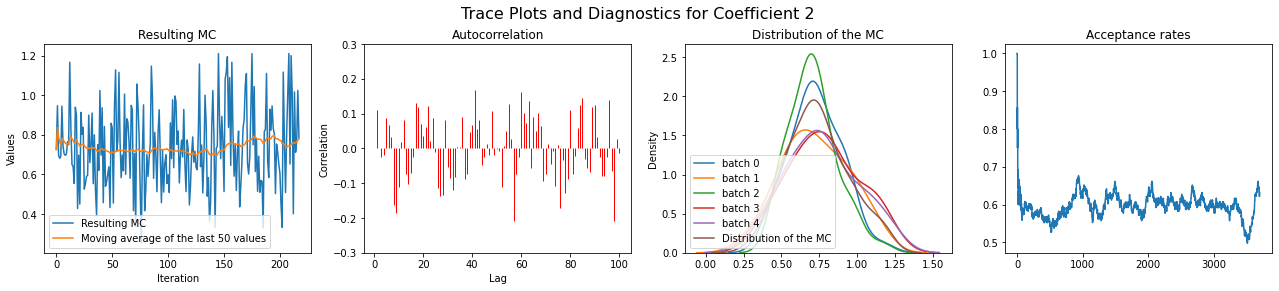

In [ ]:
# Parameters: {'b0':initial_beta_sim_norm, 'prior':multivariate_normal(initial_beta_sim_norm*np.ones(X_sim.shape[1]), np.eye(X_sim.shape[1])), 'tau':0.45}, 

metr_sim_01 = \
run_metropolis(X_sim, Y_sim, T=4000, zoom_in=1000, 
              #  burnin=300, max_step=16,
               starting_beta=parameters_combinations_sim_metr[0]['b0'], 
               prior=parameters_combinations_sim_metr[0]['prior'], 
               tau=parameters_combinations_sim_metr[0]['tau'])

Chosen burn-in period  for the MCMC:		300
Chosen step size to obtain i.i.d. samples:	15
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -0.14236 	Estimated standard error: 0.18422 	Estimated confidence interval: [-0.50342  0.2187 ]	Significant: No
Coefficient 1:	Estiamted parameter: -2.52158 	Estimated standard error: 0.49355 	Estimated confidence interval: [-3.48892 -1.55424]	Significant: Yes
Coefficient 2:	Estiamted parameter: 1.01008 	Estimated standard error: 0.29424 	Estimated confidence interval: [0.43338 1.58678]	Significant: Yes



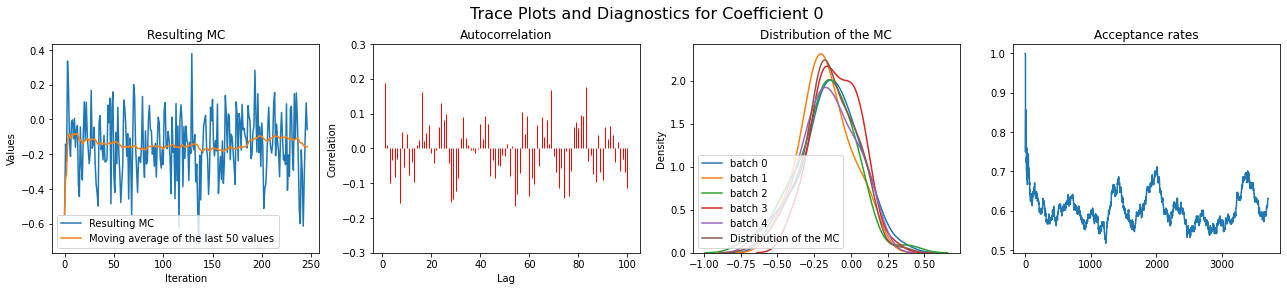

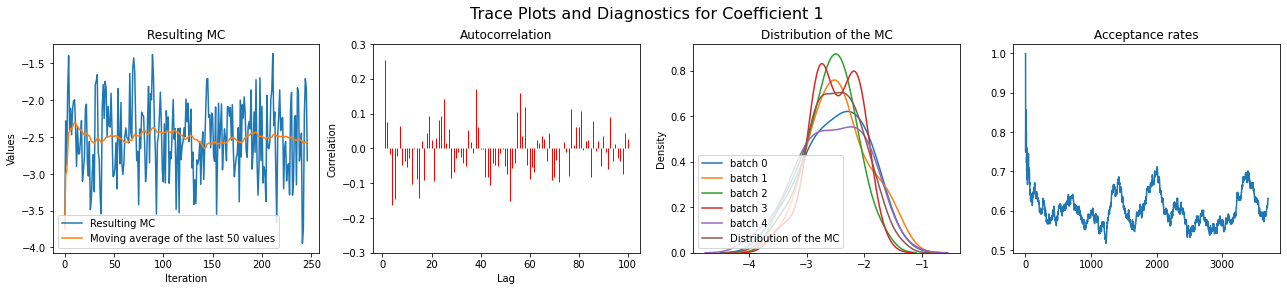

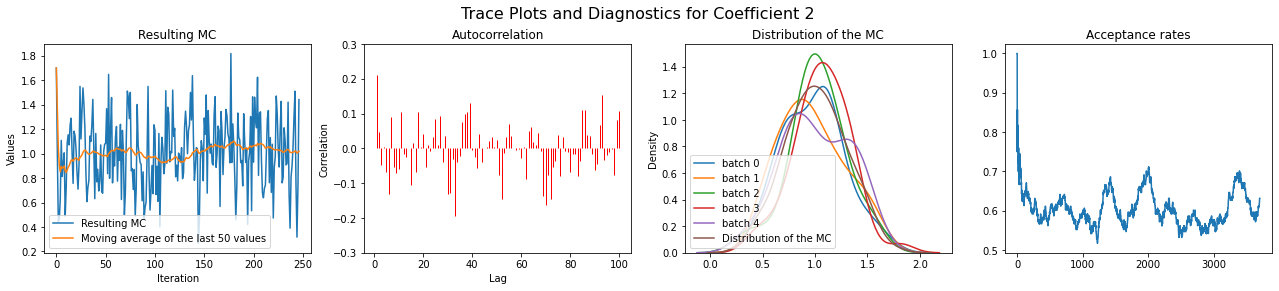

In [ ]:
# Parameters: {'b0':initial_beta_sim_norm, 'prior':1, 'tau':0.45}

metr_sim_02 = \
run_metropolis(X_sim, Y_sim, T=4000, zoom_in=1000, 
              #  burnin=300, max_step=15,
               starting_beta=parameters_combinations_sim_metr[1]['b0'], 
               prior=parameters_combinations_sim_metr[1]['prior'], 
               tau=parameters_combinations_sim_metr[1]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	23
Significance level for testing the estimates:	0.05


Coefficient 0:	Estiamted parameter: -0.1589 	Estimated standard error: 0.19363 	Estimated confidence interval: [-0.53841  0.22061]	Significant: No
Coefficient 1:	Estiamted parameter: -2.50523 	Estimated standard error: 0.52074 	Estimated confidence interval: [-3.52586 -1.4846 ]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.99011 	Estimated standard error: 0.28949 	Estimated confidence interval: [0.42272 1.5575 ]	Significant: Yes



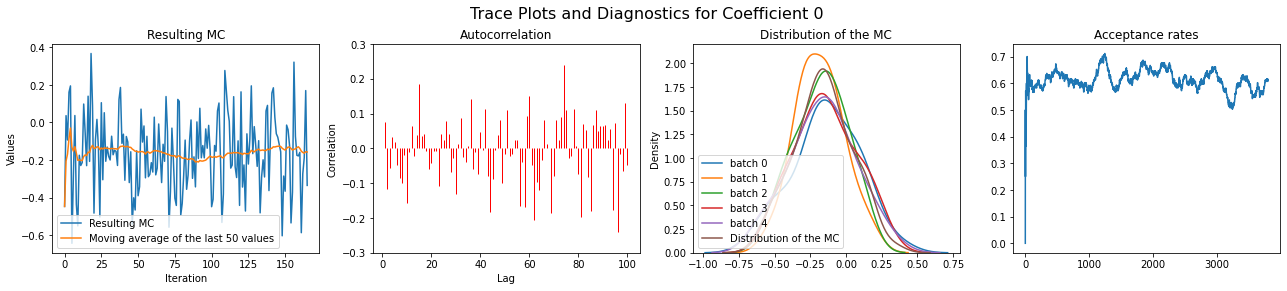

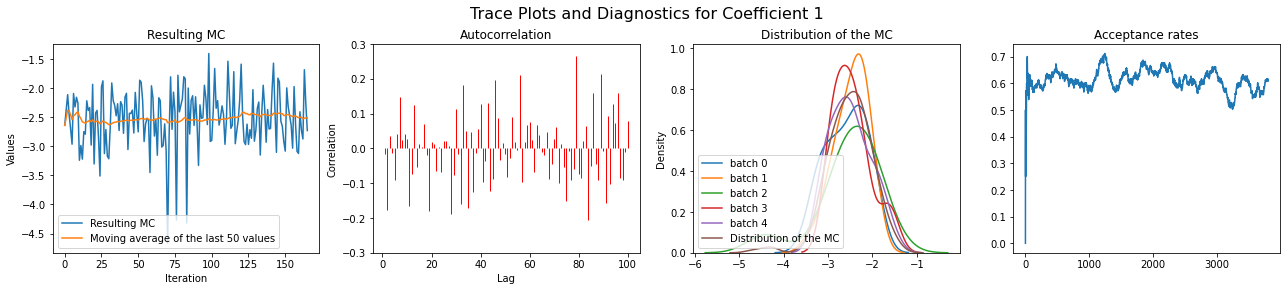

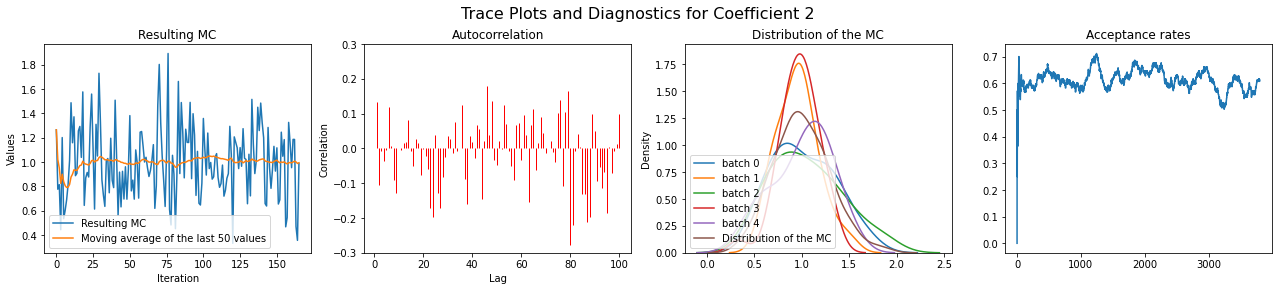

In [ ]:
# Parameters: {'b0':initial_beta_sim_probit, 'prior':1, 'tau':0.45}

metr_sim_03 = \
run_metropolis(X_sim, Y_sim, T=4000, zoom_in=1000, 
              #  burnin=100, max_step=23,
               starting_beta=parameters_combinations_sim_metr[2]['b0'], 
               prior=parameters_combinations_sim_metr[2]['prior'], 
               tau=parameters_combinations_sim_metr[2]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	24
Significance level for testing the estimates:	0.05


Coefficient 0:	Estiamted parameter: -0.14249 	Estimated standard error: 0.19584 	Estimated confidence interval: [-0.52633  0.24135]	Significant: No
Coefficient 1:	Estiamted parameter: -2.49791 	Estimated standard error: 0.41443 	Estimated confidence interval: [-3.31018 -1.68564]	Significant: Yes
Coefficient 2:	Estiamted parameter: 1.01046 	Estimated standard error: 0.25725 	Estimated confidence interval: [0.50626 1.51466]	Significant: Yes



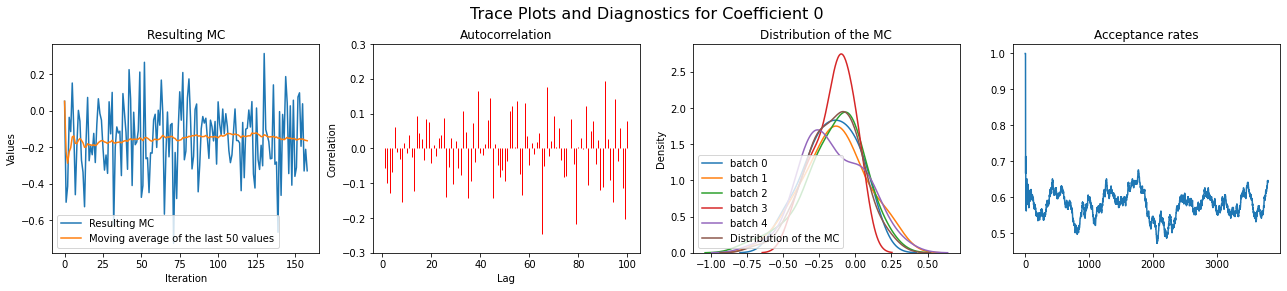

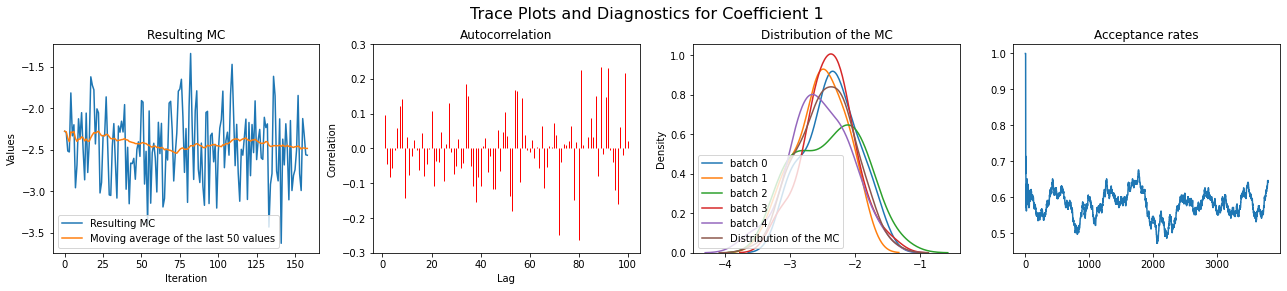

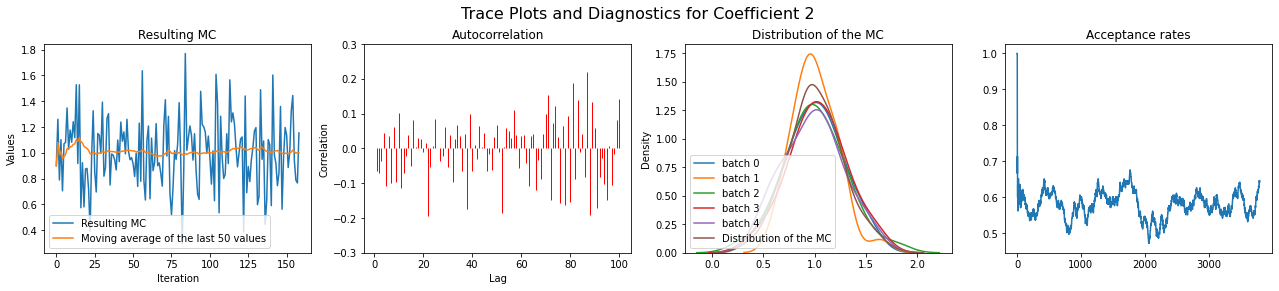

In [ ]:
# Parameters: {'b0':initial_beta_sim_probit, 'prior':multivariate_normal(initial_beta_sim_probit*np.ones(X_sim.shape[1]), np.eye(X_sim.shape[1])), 'tau':0.45}

metr_sim_04 = \
run_metropolis(X_sim, Y_sim, T=4000, zoom_in=1000, 
              #  burnin=200, max_step=24,
               starting_beta=parameters_combinations_sim_metr[3]['b0'], 
               prior=parameters_combinations_sim_metr[3]['prior'], 
               tau=parameters_combinations_sim_metr[3]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	17
Significance level for testing the estimates:	0.05


Coefficient 0:	Estiamted parameter: -0.17238 	Estimated standard error: 0.19451 	Estimated confidence interval: [-0.55361  0.20885]	Significant: No
Coefficient 1:	Estiamted parameter: -2.4834 	Estimated standard error: 0.5093 	Estimated confidence interval: [-3.48161 -1.48519]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.99054 	Estimated standard error: 0.29815 	Estimated confidence interval: [0.40618 1.5749 ]	Significant: Yes



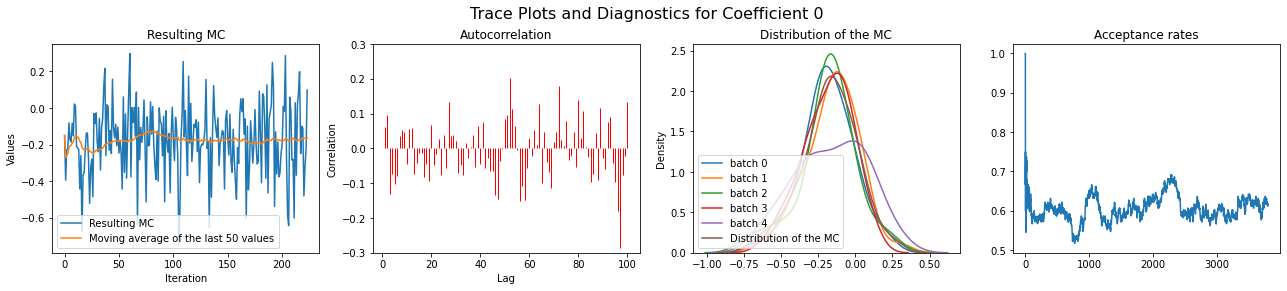

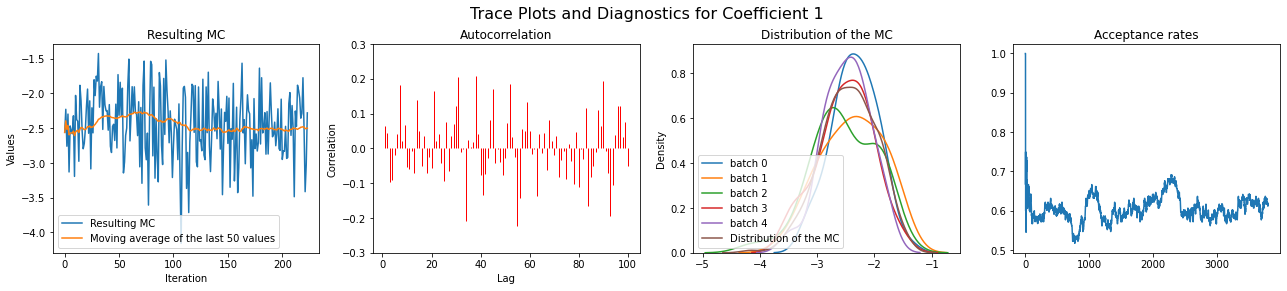

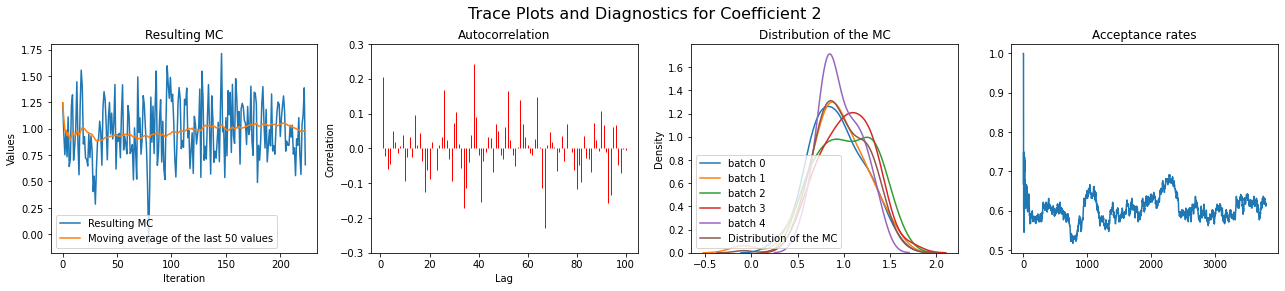

In [ ]:
# Parameters: {'b0':initial_beta_sim_probit, 'prior':multivariate_normal(initial_beta_sim_probit*np.ones(X_sim.shape[1]), 5*np.eye(X_sim.shape[1])), 'tau':0.45}

metr_sim_05 = \
run_metropolis(X_sim, Y_sim, T=4000, zoom_in=1000, 
              #  burnin=200, max_step=17,
               starting_beta=parameters_combinations_sim_metr[4]['b0'], 
               prior=parameters_combinations_sim_metr[4]['prior'], 
               tau=parameters_combinations_sim_metr[4]['tau'])

Chosen burn-in period  for the MCMC:		400
Chosen step size to obtain i.i.d. samples:	23
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -0.17845 	Estimated standard error: 0.20879 	Estimated confidence interval: [-0.58767  0.23077]	Significant: No
Coefficient 1:	Estiamted parameter: -2.50371 	Estimated standard error: 0.44225 	Estimated confidence interval: [-3.3705  -1.63692]	Significant: Yes
Coefficient 2:	Estiamted parameter: 1.00309 	Estimated standard error: 0.27083 	Estimated confidence interval: [0.47227 1.53391]	Significant: Yes



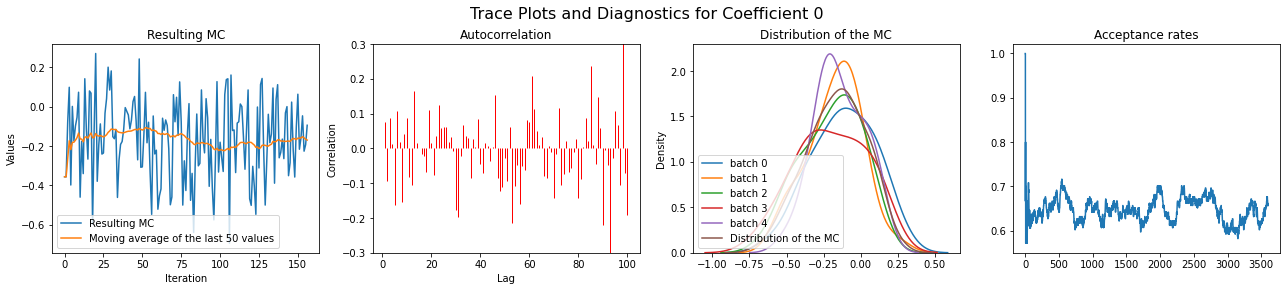

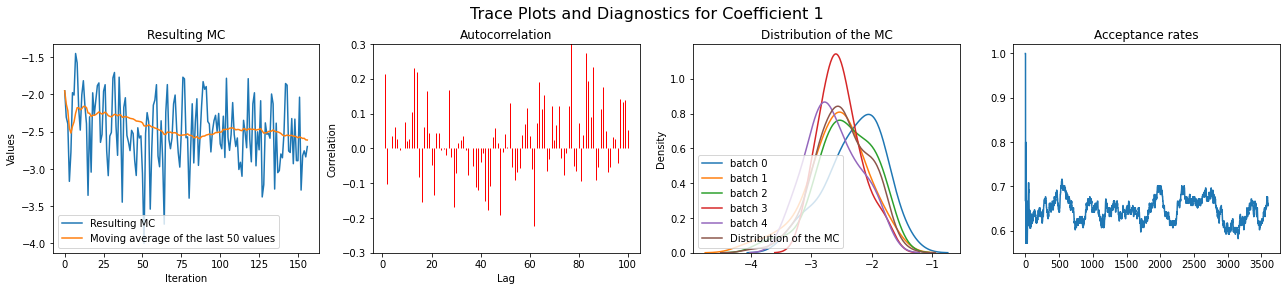

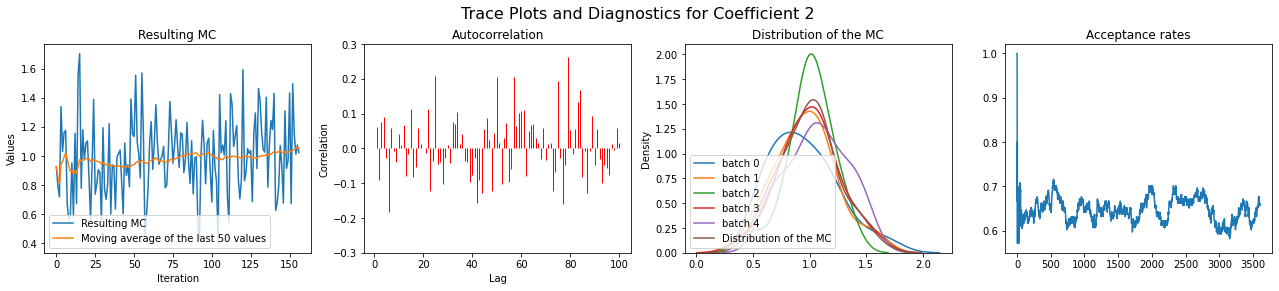

In [ ]:
# Parameters: {'b0':initial_beta_sim_probit, 'prior':multivariate_normal(initial_beta_sim_probit*np.ones(X_sim.shape[1]), np.eye(X_sim.shape[1])), 'tau':0.30}

metr_sim_06 = \
run_metropolis(X_sim, Y_sim, T=4000, zoom_in=1000, 
              #  burnin=400, max_step=23,
               starting_beta=parameters_combinations_sim_metr[5]['b0'], 
               prior=parameters_combinations_sim_metr[5]['prior'], 
               tau=parameters_combinations_sim_metr[5]['tau'])

#### Auxiliary Gibbs Sampler

Chosen burn-in period  for the MCMC:		50
Chosen step size to obtain i.i.d. samples:	20
Significance level for testing the estimates:	0.05


Coefficient 0:	Estiamted parameter: -0.00955 	Estimated standard error: 0.18107 	Estimated confidence interval: [-0.36444  0.34534]	Significant: No
Coefficient 1:	Estiamted parameter: -1.80407 	Estimated standard error: 0.33437 	Estimated confidence interval: [-2.45942 -1.14872]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.8316 	Estimated standard error: 0.23819 	Estimated confidence interval: [0.36476 1.29844]	Significant: Yes



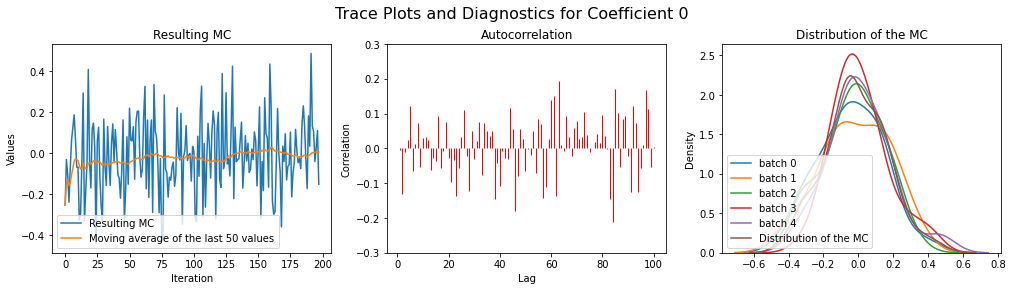

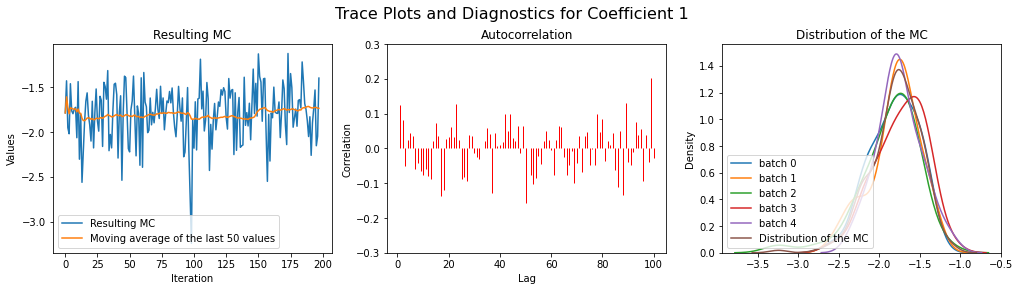

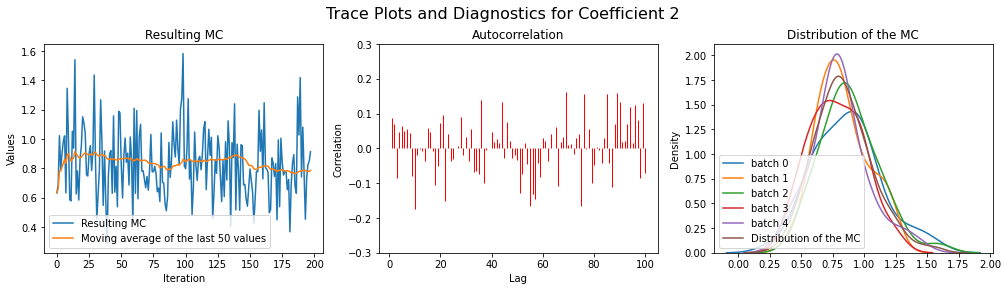

In [ ]:
# Parameters: {'b0':initial_beta_sim_norm, 'prior':(initial_beta_sim_norm, 5*np.eye(X_sim.shape[1]))}

gibb_sim_01 = \
run_aux_gibbs(X_sim, Y_sim, T=50, zoom_in=20,
              #  burnin=50, max_step=20,
              starting_beta=parameters_combinations_sim_gibb[0]['b0'], 
              informative_prior=parameters_combinations_sim_gibb[0]['prior'])

Chosen burn-in period  for the MCMC:		100
Chosen step size to obtain i.i.d. samples:	20
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -0.16916 	Estimated standard error: 0.18827 	Estimated confidence interval: [-0.53816  0.19984]	Significant: No
Coefficient 1:	Estiamted parameter: -2.73394 	Estimated standard error: 0.51715 	Estimated confidence interval: [-3.74754 -1.72034]	Significant: Yes
Coefficient 2:	Estiamted parameter: 1.09311 	Estimated standard error: 0.31431 	Estimated confidence interval: [0.47707 1.70915]	Significant: Yes



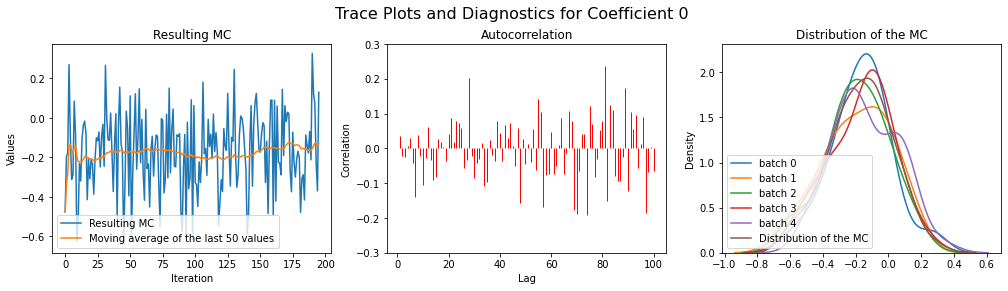

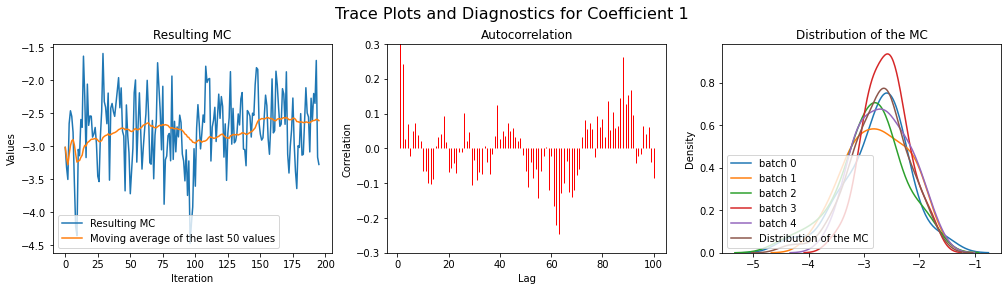

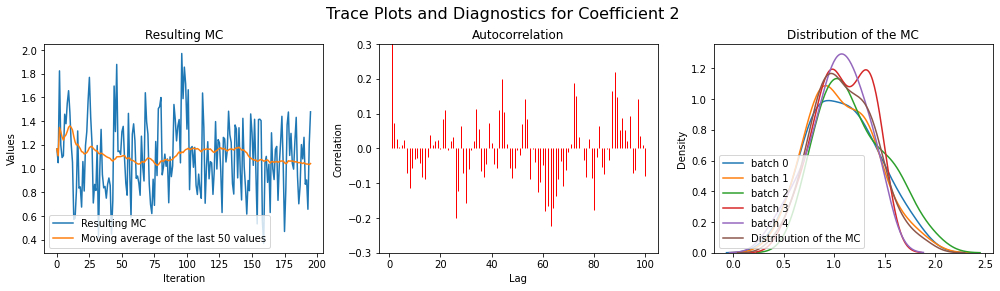

In [ ]:
# Parameters: {'b0':initial_beta_sim_norm, 'prior':False}

gibb_sim_02 = \
run_aux_gibbs(X_sim, Y_sim, T=4000, zoom_in=300,
              #  burnin=100, max_step=20,
              starting_beta=parameters_combinations_sim_gibb[1]['b0'], 
              informative_prior=parameters_combinations_sim_gibb[1]['prior'])

Chosen burn-in period  for the MCMC:		50
Chosen step size to obtain i.i.d. samples:	25
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15
No valid subsamples have been found, retrying with threshold = 0.25

Coefficient 0:	Estiamted parameter: -0.1797 	Estimated standard error: 0.19626 	Estimated confidence interval: [-0.56436  0.20496]	Significant: No
Coefficient 1:	Estiamted parameter: -2.79831 	Estimated standard error: 0.49587 	Estimated confidence interval: [-3.7702  -1.82642]	Significant: Yes
Coefficient 2:	Estiamted parameter: 1.11175 	Estimated standard error: 0.30446 	Estimated confidence interval: [0.51502 1.70848]	Significant: Yes



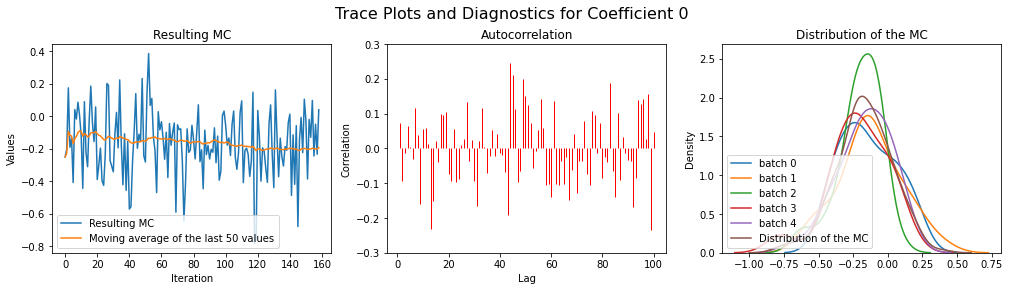

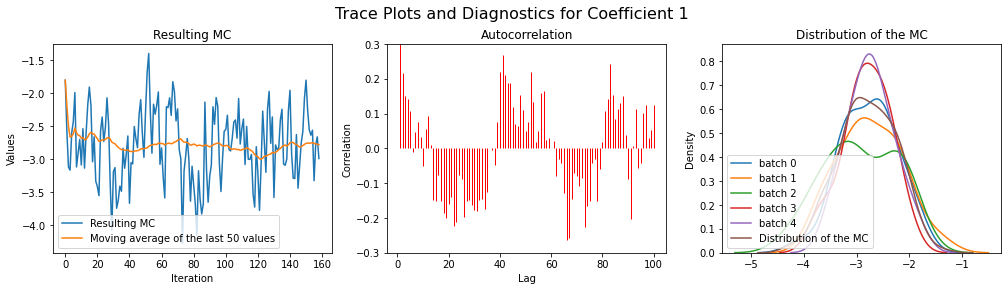

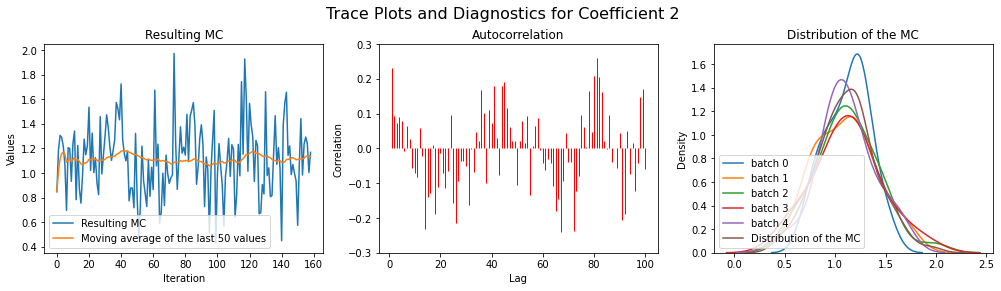

In [ ]:
# Parameters: {'b0':initial_beta_sim_probit, 'prior':False}

gibb_sim_03 = \
run_aux_gibbs(X_sim, Y_sim, T=4000, zoom_in=300,
              #  burnin=50, max_step=25,
              starting_beta=parameters_combinations_sim_gibb[2]['b0'], 
              informative_prior=parameters_combinations_sim_gibb[2]['prior'])

Chosen burn-in period  for the MCMC:		100
Chosen step size to obtain i.i.d. samples:	27
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -0.18764 	Estimated standard error: 0.20842 	Estimated confidence interval: [-0.59614  0.22086]	Significant: No
Coefficient 1:	Estiamted parameter: -2.82917 	Estimated standard error: 0.5461 	Estimated confidence interval: [-3.89951 -1.75883]	Significant: Yes
Coefficient 2:	Estiamted parameter: 1.12808 	Estimated standard error: 0.30902 	Estimated confidence interval: [0.52241 1.73375]	Significant: Yes



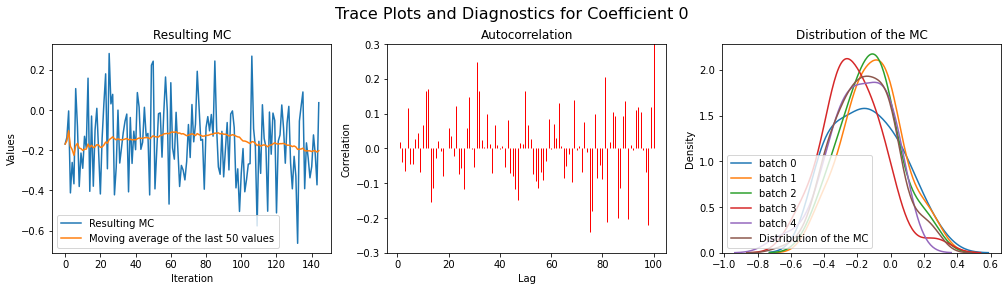

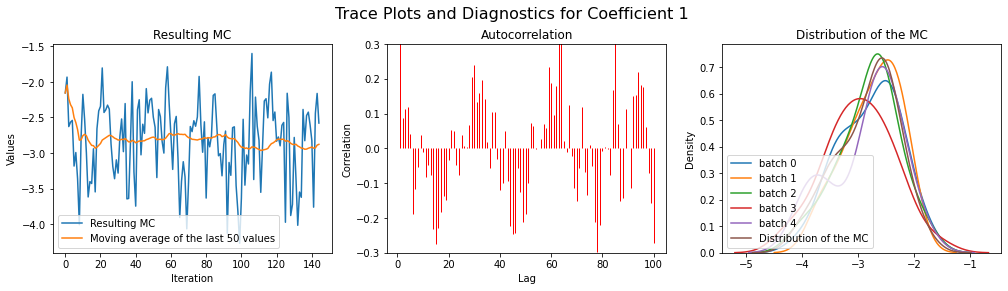

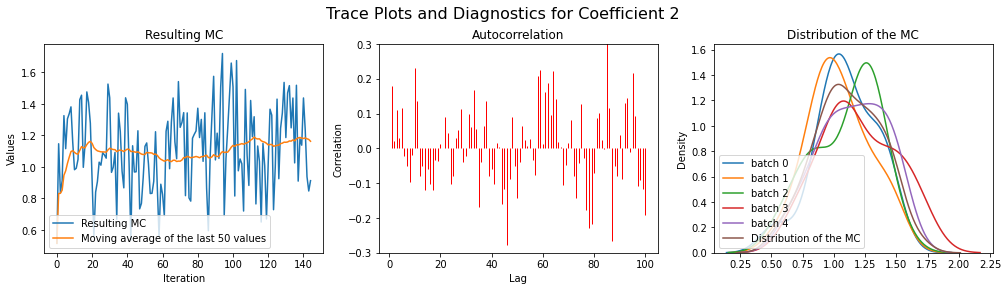

In [ ]:
# Parameters: {'b0':initial_beta_sim_probit, 'prior':(initial_beta_sim_probit, 5*np.eye(X_sim.shape[1]))}

gibb_sim_04 = \
run_aux_gibbs(X_sim, Y_sim, T=4000, zoom_in=300,
              #  burnin=100, max_step=27,
              starting_beta=parameters_combinations_sim_gibb[3]['b0'], 
              informative_prior=parameters_combinations_sim_gibb[3]['prior'])

### Real Data

#### Importing some real datasets

In [ ]:
# Real dataset

#data_to_use = 'iris'
#data_to_use = 'breast cancer'
data_to_use = 'wine'

if data_to_use == 'iris': 
  iris = datasets.load_iris()
  Y_real = iris.target[iris.target!=0] - 1
  X_real = iris.data[iris.target!=0][:,[1,3]]
  const = np.ones((len(X_real),1))
  X_real = np.hstack((const,X_real))

elif data_to_use == 'breast cancer':
  breast_c = datasets.load_breast_cancer()
  Y_real = breast_c.target
  X_real = breast_c.data

elif data_to_use == 'wine':
  wine = datasets.load_wine()
  Y_real = wine.target[wine.target!=0] - 1
  X_real = wine.data[wine.target!=0][:,2:6]

# pca = PCA(n_components=2)
# X_real = pca.fit_transform(X_real)

const = np.ones((len(X_real),1))
X_real = np.hstack((const,X_real))

In [ ]:
model = dm.Probit(Y_real, X_real)
probit_real_results = model.fit()
print(probit_real_results.summary())

Optimization terminated successfully.
         Current function value: 0.425102
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  119
Model:                         Probit   Df Residuals:                      114
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Jan 2022   Pseudo R-squ.:                  0.3696
Time:                        21:16:39   Log-Likelihood:                -50.587
converged:                       True   LL-Null:                       -80.248
Covariance Type:            nonrobust   LLR p-value:                 4.028e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0077      1.634     -1.840      0.066      -6.211       0.196
x1             2.3441      0.

In [ ]:
# Assign priors, taus and initial betas to test the model on different configurations
initial_beta_real_uni = np.random.uniform(low=-10, high=10, size=X_real.shape[1])
initial_beta_real_norm = np.random.normal(0, scale=2, size=X_real.shape[1])
initial_beta_real_probit = probit_real_results.params


# Actual parameters that will be tested
parameters_combinations_real_metr = [{'b0':initial_beta_real_norm, 'prior':multivariate_normal(initial_beta_real_norm*np.ones(X_real.shape[1]), np.eye(X_real.shape[1])), 'tau':0.45}, 
                                    {'b0':initial_beta_real_norm, 'prior':1, 'tau':0.45}, 
                                    {'b0':initial_beta_real_probit, 'prior':1, 'tau':0.45},
                                    {'b0':initial_beta_real_probit, 'prior':multivariate_normal(initial_beta_real_probit*np.ones(X_real.shape[1]), np.eye(X_real.shape[1])), 'tau':0.45}, 
                                    {'b0':initial_beta_real_probit, 'prior':multivariate_normal(initial_beta_real_probit*np.ones(X_real.shape[1]), 5*np.eye(X_real.shape[1])), 'tau':0.45},
                                    {'b0':initial_beta_real_probit, 'prior':multivariate_normal(initial_beta_real_probit*np.ones(X_real.shape[1]), np.eye(X_real.shape[1])), 'tau':0.30}]

parameters_combinations_real_gibb = [{'b0':initial_beta_real_norm, 'prior':(initial_beta_real_probit, np.eye(X_real.shape[1]))}, 
                                    {'b0':initial_beta_real_norm, 'prior':False}, 
                                    {'b0':initial_beta_real_probit, 'prior':False}, 
                                    {'b0':initial_beta_real_probit, 'prior':(initial_beta_real_probit, 5*np.eye(X_real.shape[1]))}]

#### Metropolis Sampler

Chosen burn-in period  for the MCMC:		400
Chosen step size to obtain i.i.d. samples:	17
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: 0.15993 	Estimated standard error: 0.83299 	Estimated confidence interval: [-1.4727   1.79256]	Significant: No
Coefficient 1:	Estiamted parameter: 1.65607 	Estimated standard error: 0.57352 	Estimated confidence interval: [0.53199 2.78015]	Significant: Yes
Coefficient 2:	Estiamted parameter: -0.02701 	Estimated standard error: 0.05949 	Estimated confidence interval: [-0.14361  0.08959]	Significant: No
Coefficient 3:	Estiamted parameter: -0.00021 	Estimated standard error: 0.00841 	Estimated confidence interval: [-0.01669  0.01627]	Significant: No
Coefficient 4:	Estiamted parameter: -1.91254 	Estimated standard error: 0.32908 	Estimated confidence interval: [-2.55752 -1.26756]	Significant: Yes



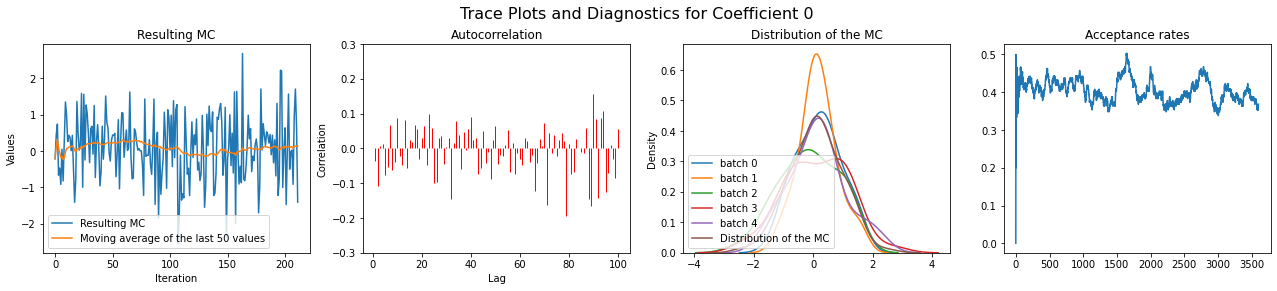

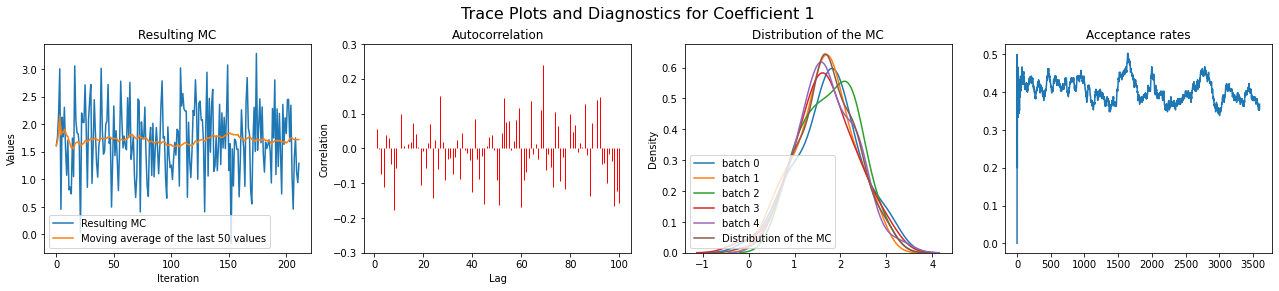

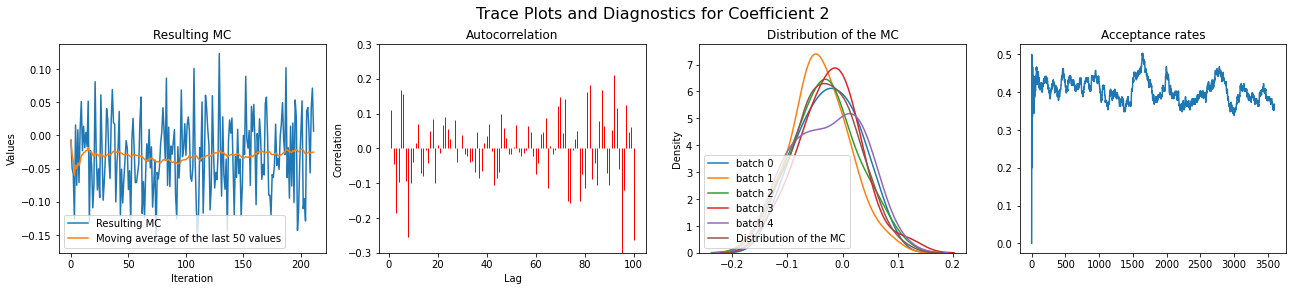

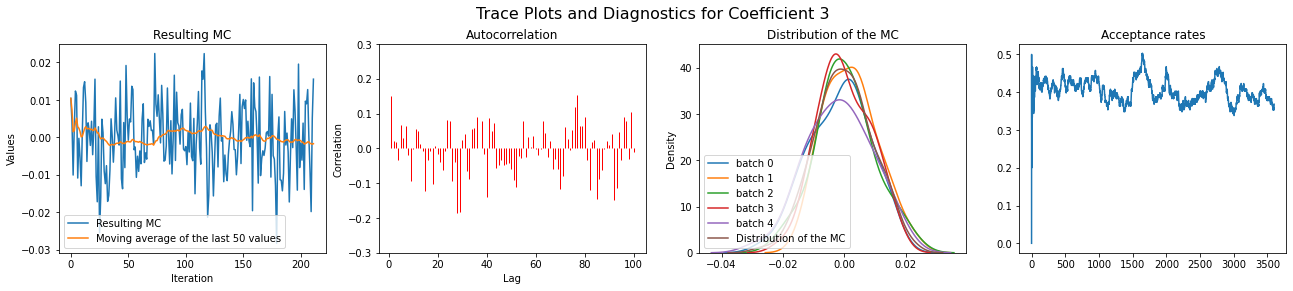

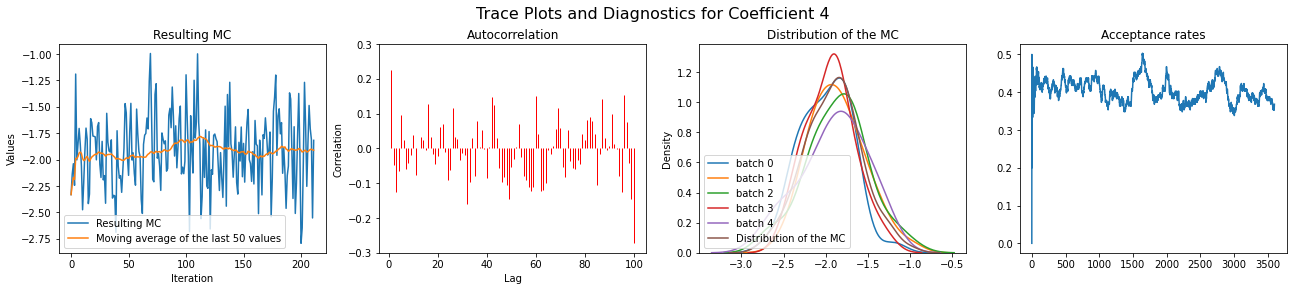

In [ ]:
# Parameters: {'b0':initial_beta_real_norm, 'prior':multivariate_normal(initial_beta_real_norm*np.ones(X_real.shape[1]), np.eye(X_real.shape[1])), 'tau':0.45}, 

metr_real_01 = \
run_metropolis(X_real, Y_real, T=4000, zoom_in=1000, 
              #  burnin=400, max_step=17,
               starting_beta=parameters_combinations_real_metr[0]['b0'], 
               prior=parameters_combinations_real_metr[0]['prior'], 
               tau=parameters_combinations_real_metr[0]['tau'])

Chosen burn-in period  for the MCMC:		400
Chosen step size to obtain i.i.d. samples:	20
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -2.97087 	Estimated standard error: 1.61805 	Estimated confidence interval: [-6.14219  0.20045]	Significant: No
Coefficient 1:	Estiamted parameter: 2.18344 	Estimated standard error: 0.74642 	Estimated confidence interval: [0.72048 3.6464 ]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.01516 	Estimated standard error: 0.06519 	Estimated confidence interval: [-0.11261  0.14293]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00921 	Estimated standard error: 0.00954 	Estimated confidence interval: [-0.00949  0.02791]	Significant: No
Coefficient 4:	Estiamted parameter: -1.87564 	Estimated standard error: 0.32853 	Estimated confidence interval: [-2.51955 -1.23173]	Significant: Yes



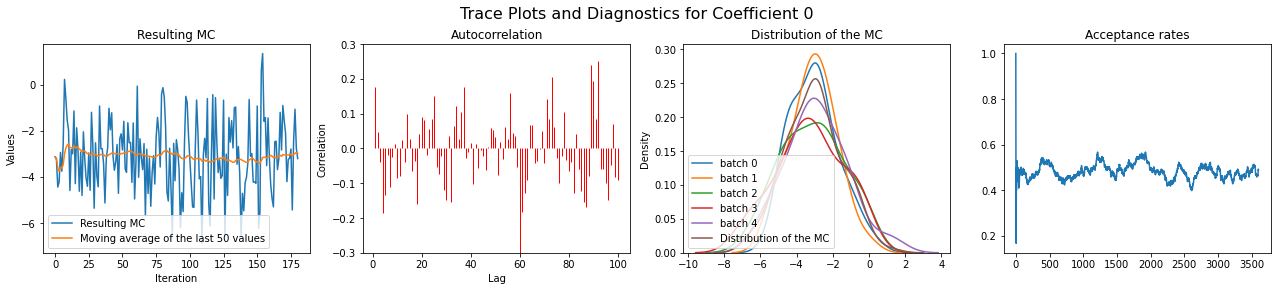

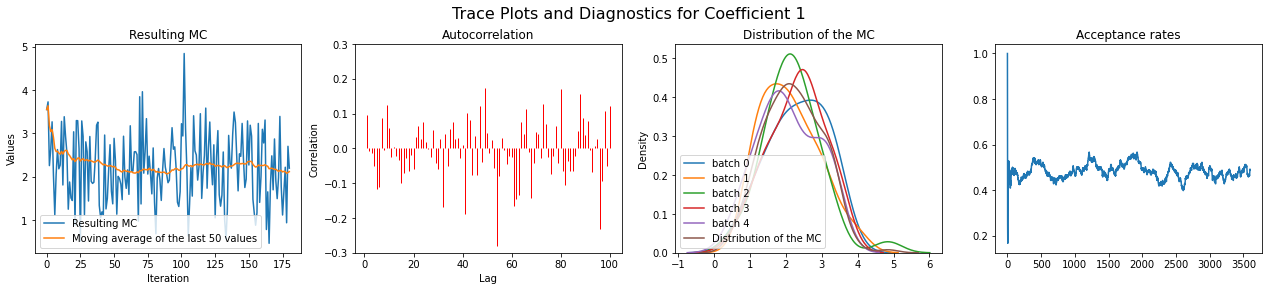

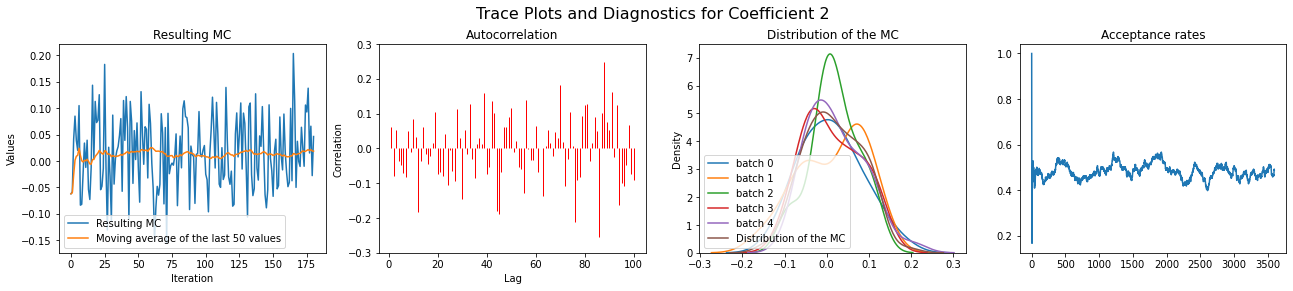

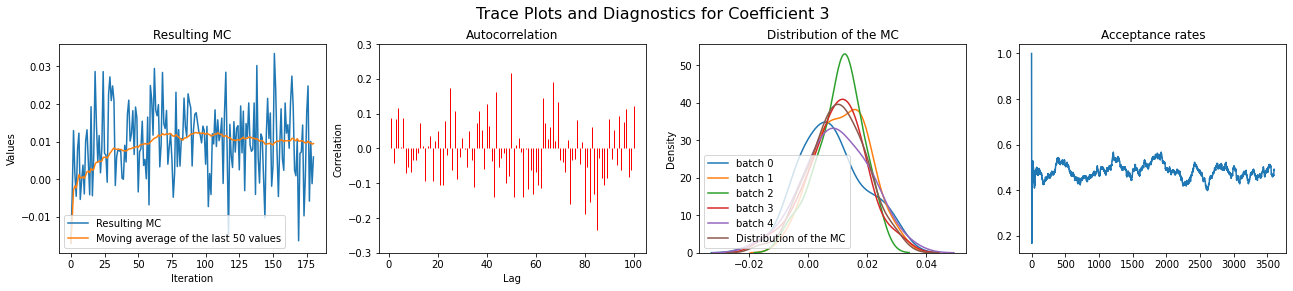

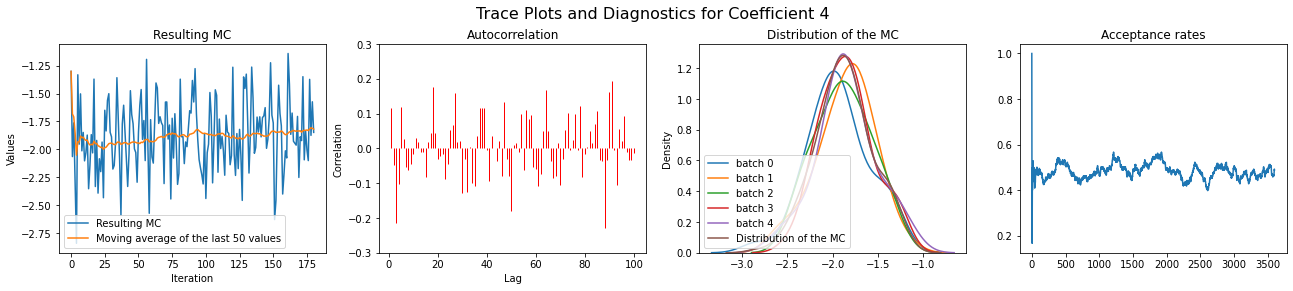

In [ ]:
# Parameters: {'b0':initial_beta_real_norm, 'prior':1, 'tau':0.45}

metr_real_02 = \
run_metropolis(X_real, Y_real, T=4000, zoom_in=1000, 
              #  burnin=400, max_step=20,
               starting_beta=parameters_combinations_real_metr[1]['b0'], 
               prior=parameters_combinations_real_metr[1]['prior'], 
               tau=parameters_combinations_real_metr[1]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	20
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -2.74944 	Estimated standard error: 1.56489 	Estimated confidence interval: [-5.81657  0.31769]	Significant: No
Coefficient 1:	Estiamted parameter: 2.09374 	Estimated standard error: 0.82264 	Estimated confidence interval: [0.4814  3.70608]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.01214 	Estimated standard error: 0.06847 	Estimated confidence interval: [-0.12206  0.14634]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00888 	Estimated standard error: 0.00982 	Estimated confidence interval: [-0.01037  0.02813]	Significant: No
Coefficient 4:	Estiamted parameter: -1.83528 	Estimated standard error: 0.35147 	Estimated confidence interval: [-2.52415 -1.14641]	Significant: Yes



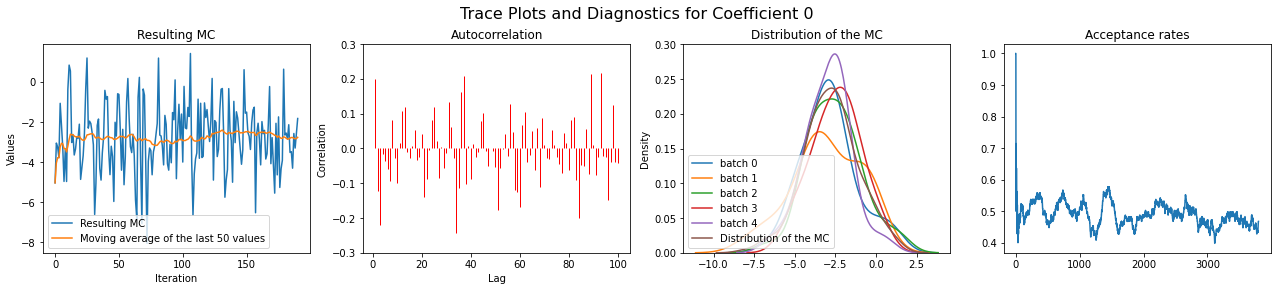

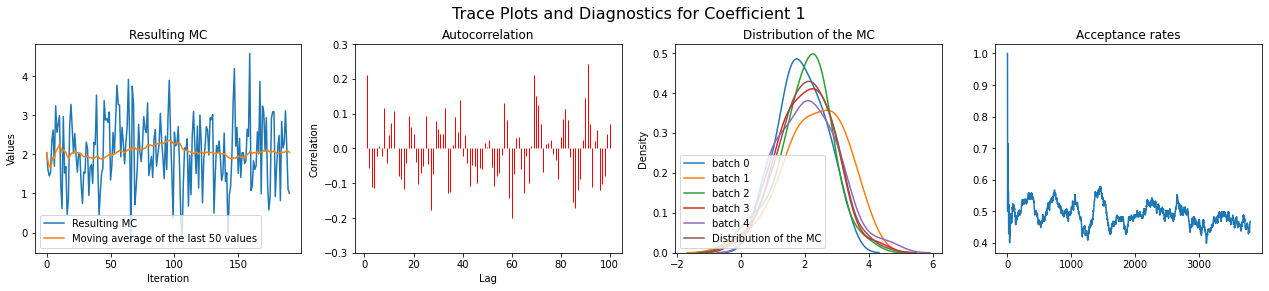

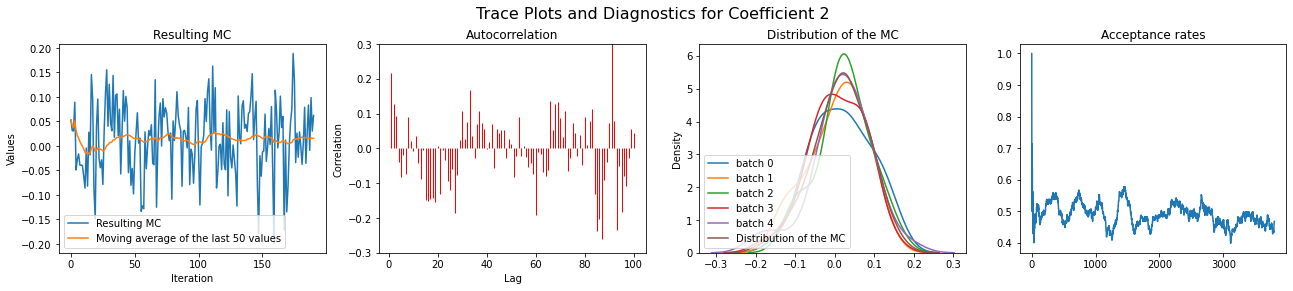

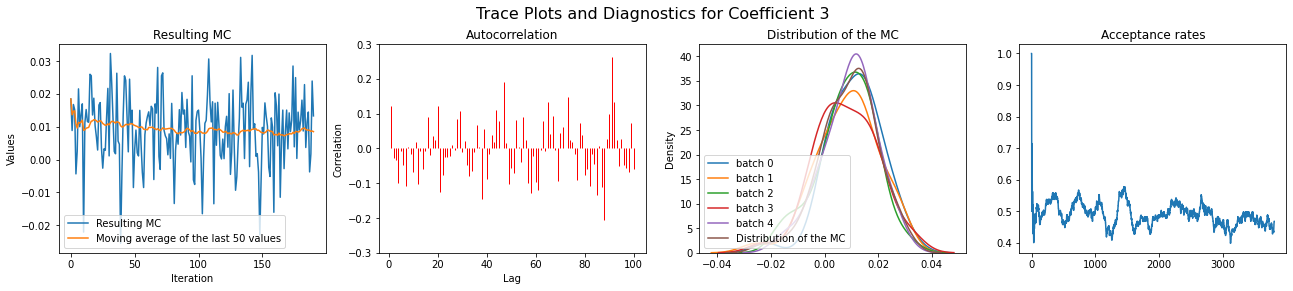

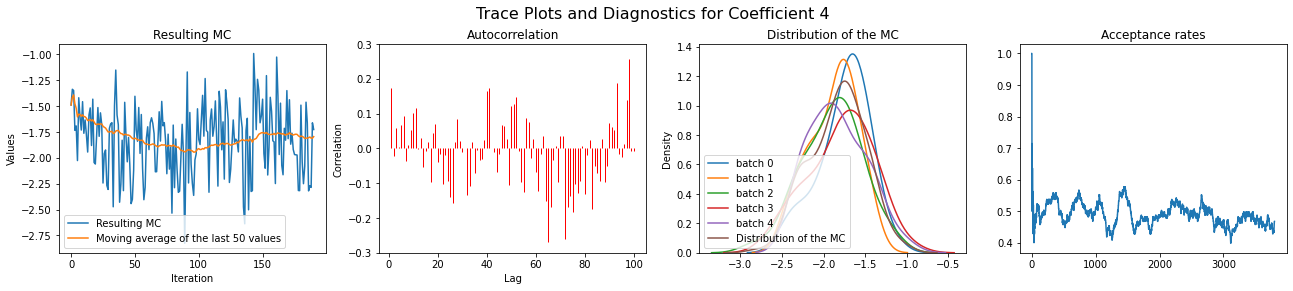

In [ ]:
# Parameters: {'b0':initial_beta_real_probit, 'prior':1, 'tau':0.45}

metr_real_03 = \
run_metropolis(X_real, Y_real, T=4000, zoom_in=1000, 
              #  burnin=200, max_step=20,
               starting_beta=parameters_combinations_real_metr[2]['b0'], 
               prior=parameters_combinations_real_metr[2]['prior'], 
               tau=parameters_combinations_real_metr[2]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	20
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -2.97604 	Estimated standard error: 0.85483 	Estimated confidence interval: [-4.65148 -1.3006 ]	Significant: Yes
Coefficient 1:	Estiamted parameter: 2.18941 	Estimated standard error: 0.5806 	Estimated confidence interval: [1.05145 3.32737]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.01675 	Estimated standard error: 0.05872 	Estimated confidence interval: [-0.09834  0.13184]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00923 	Estimated standard error: 0.00937 	Estimated confidence interval: [-0.00913  0.02759]	Significant: No
Coefficient 4:	Estiamted parameter: -1.90765 	Estimated standard error: 0.31192 	Estimated confidence interval: [-2.519  -1.2963]	Significant: Yes



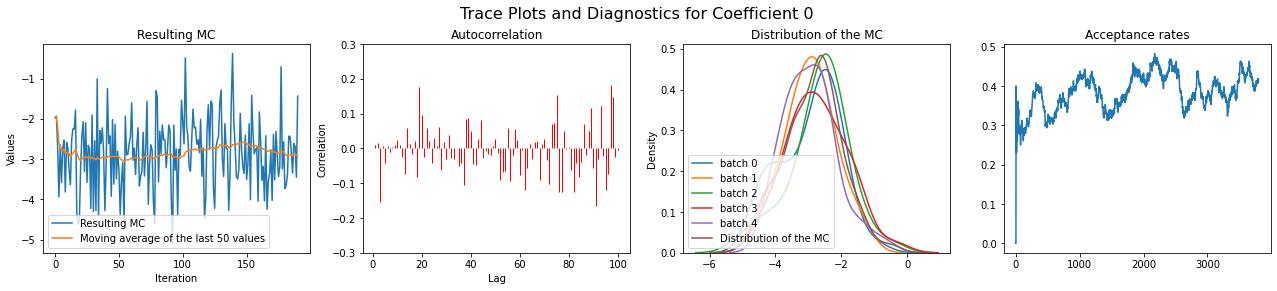

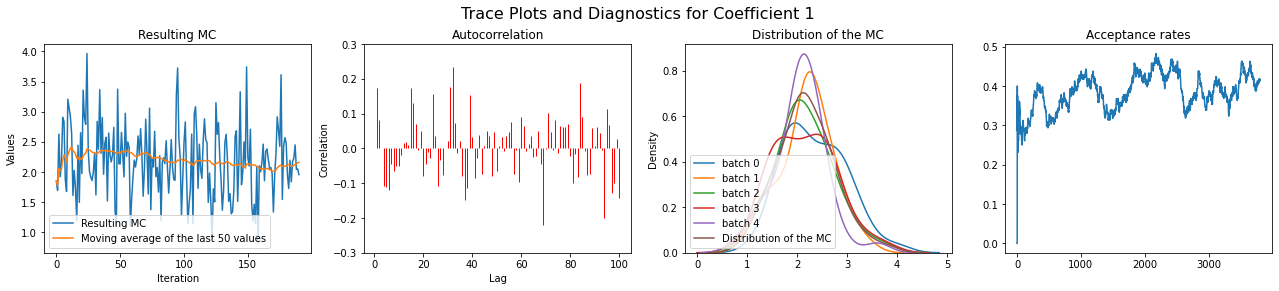

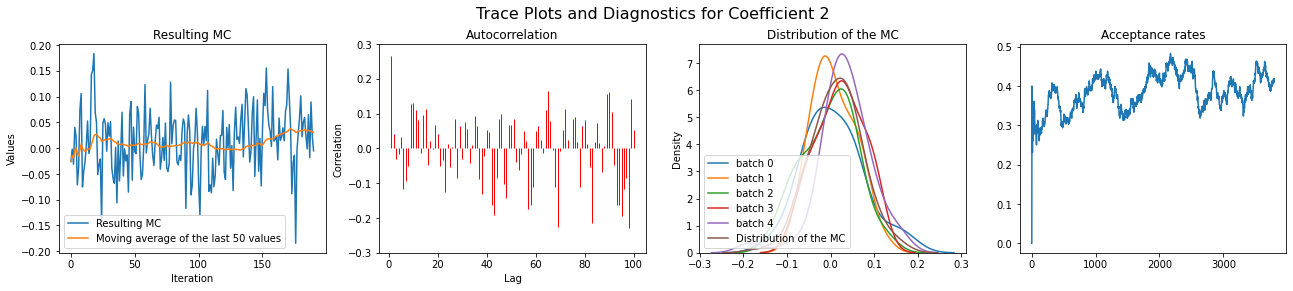

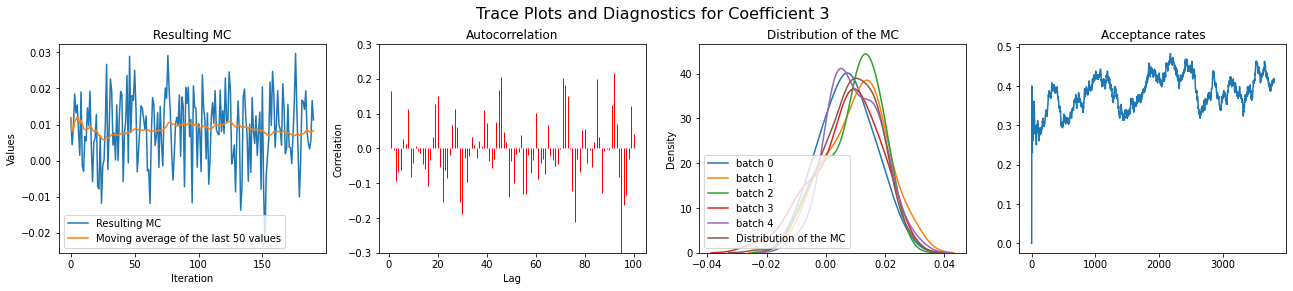

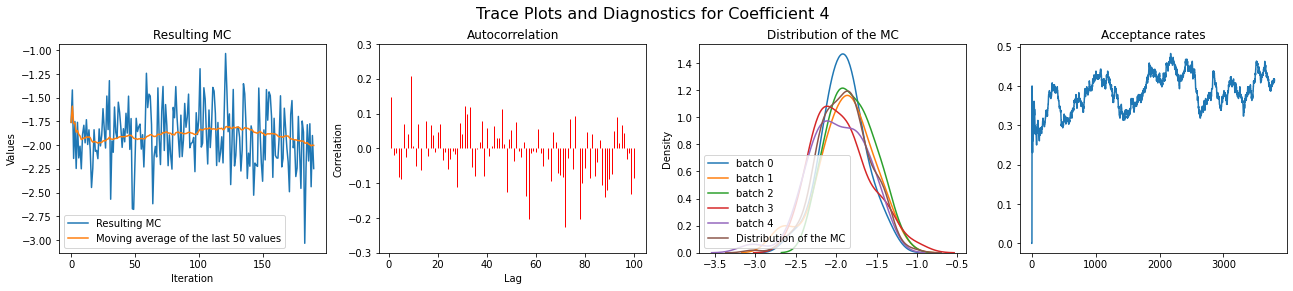

In [ ]:
# Parameters: {'b0':initial_beta_real_probit, 'prior':multivariate_normal(initial_beta_real_probit*np.ones(X_real.shape[1]), np.eye(X_real.shape[1])), 'tau':0.45}

metr_real_04 = \
run_metropolis(X_real, Y_real, T=4000, zoom_in=1000, 
              #  burnin=200, max_step=20,
               starting_beta=parameters_combinations_real_metr[3]['b0'], 
               prior=parameters_combinations_real_metr[3]['prior'], 
               tau=parameters_combinations_real_metr[3]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	20
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -2.81628 	Estimated standard error: 1.3775 	Estimated confidence interval: [-5.51613 -0.11643]	Significant: Yes
Coefficient 1:	Estiamted parameter: 2.13656 	Estimated standard error: 0.74089 	Estimated confidence interval: [0.68444 3.58868]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.01178 	Estimated standard error: 0.07089 	Estimated confidence interval: [-0.12716  0.15072]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00956 	Estimated standard error: 0.00951 	Estimated confidence interval: [-0.00908  0.0282 ]	Significant: No
Coefficient 4:	Estiamted parameter: -1.88203 	Estimated standard error: 0.35581 	Estimated confidence interval: [-2.5794  -1.18466]	Significant: Yes



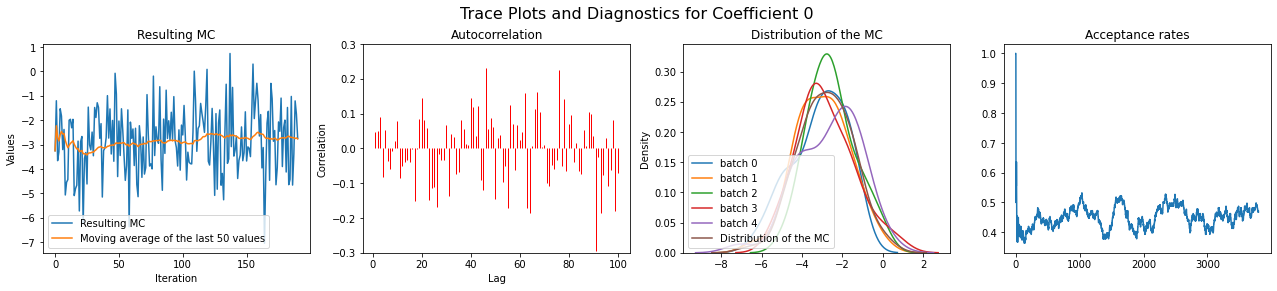

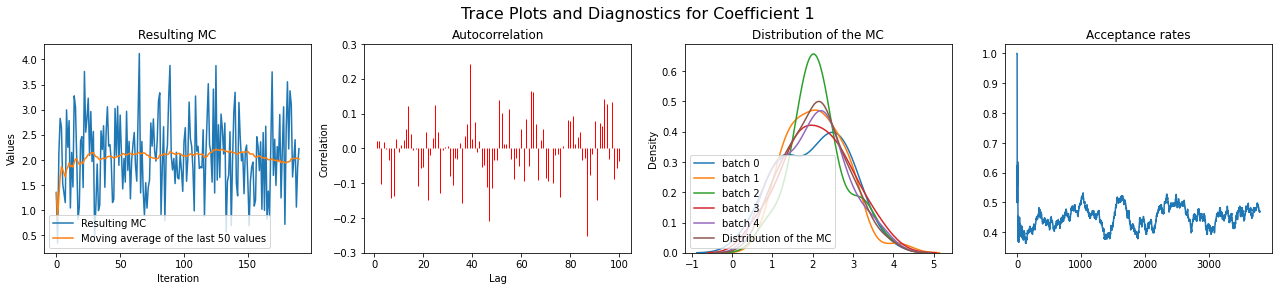

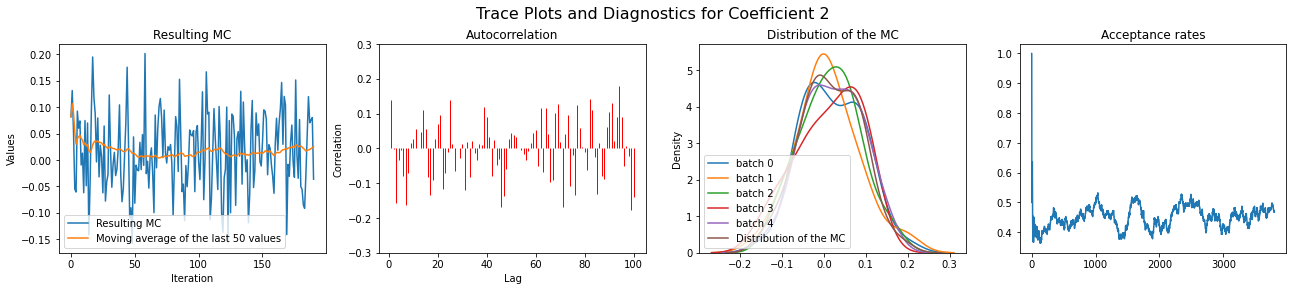

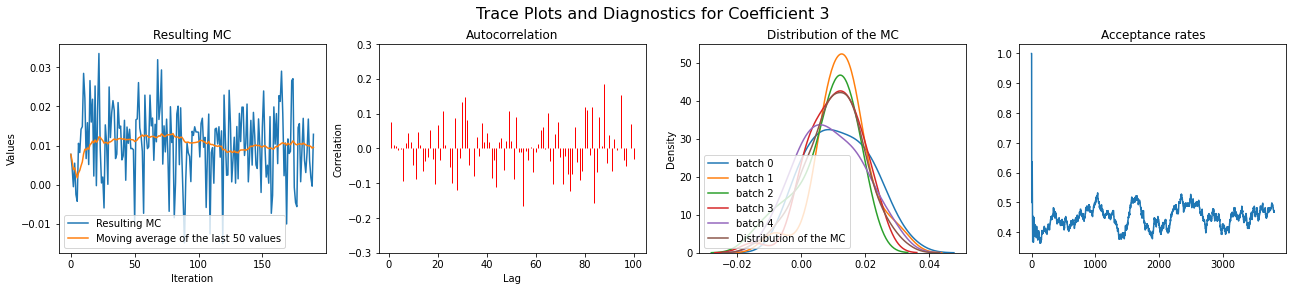

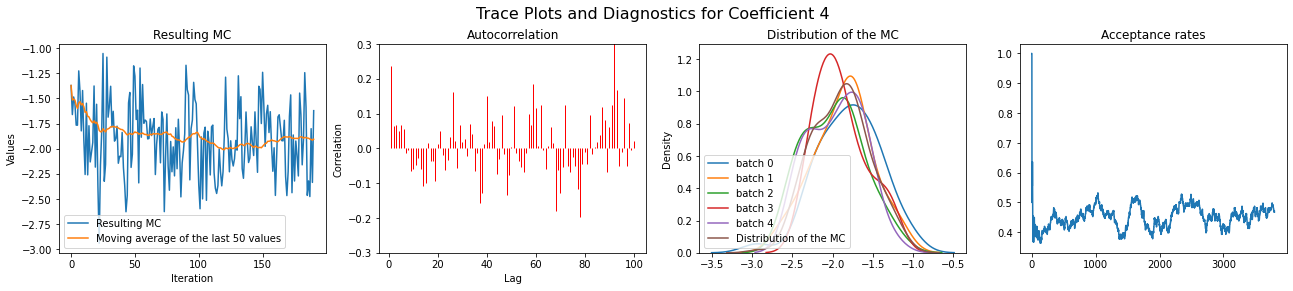

In [ ]:
# Parameters: {'b0':initial_beta_real_probit, 'prior':multivariate_normal(initial_beta_real_probit*np.ones(X_real.shape[1]), 5*np.eye(X_real.shape[1])), 'tau':0.45}

metr_real_05 = \
run_metropolis(X_real, Y_real, T=4000, zoom_in=1000, 
              #  burnin=200, max_step=20,
               starting_beta=parameters_combinations_real_metr[4]['b0'], 
               prior=parameters_combinations_real_metr[4]['prior'], 
               tau=parameters_combinations_real_metr[4]['tau'])

Chosen burn-in period  for the MCMC:		200
Chosen step size to obtain i.i.d. samples:	21
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -2.95064 	Estimated standard error: 0.84512 	Estimated confidence interval: [-4.60704 -1.29424]	Significant: Yes
Coefficient 1:	Estiamted parameter: 2.2703 	Estimated standard error: 0.56514 	Estimated confidence interval: [1.16265 3.37795]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.0026 	Estimated standard error: 0.05485 	Estimated confidence interval: [-0.1049  0.1101]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00866 	Estimated standard error: 0.00837 	Estimated confidence interval: [-0.00774  0.02506]	Significant: No
Coefficient 4:	Estiamted parameter: -1.8328 	Estimated standard error: 0.30976 	Estimated confidence interval: [-2.43992 -1.22568]	Significant: Yes



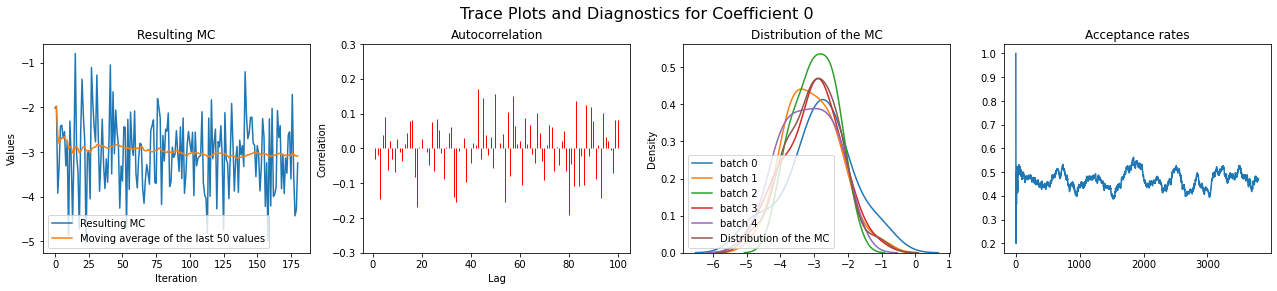

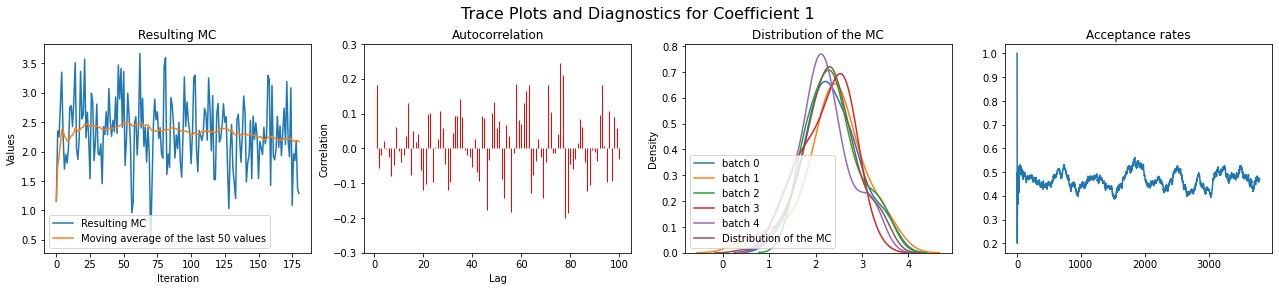

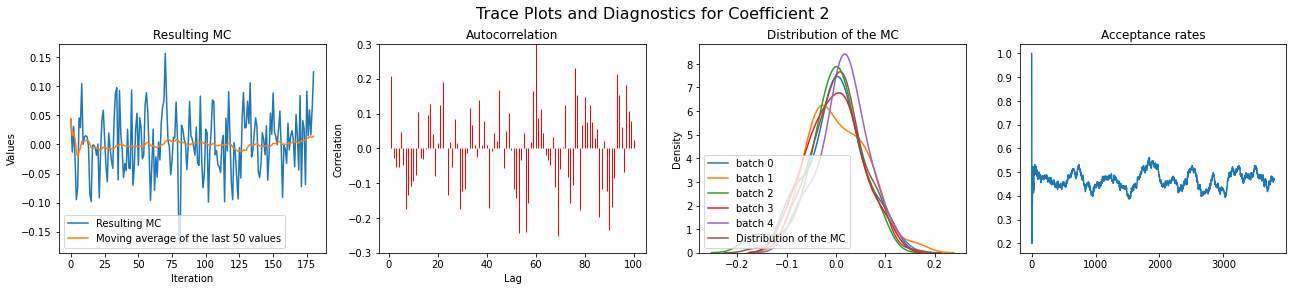

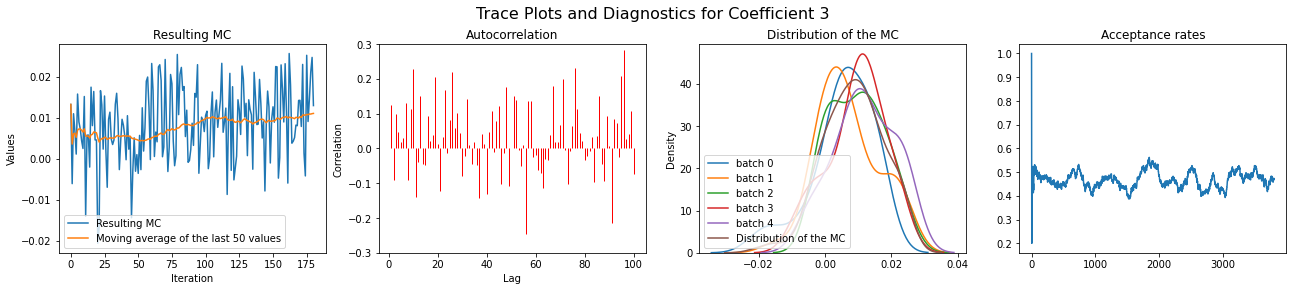

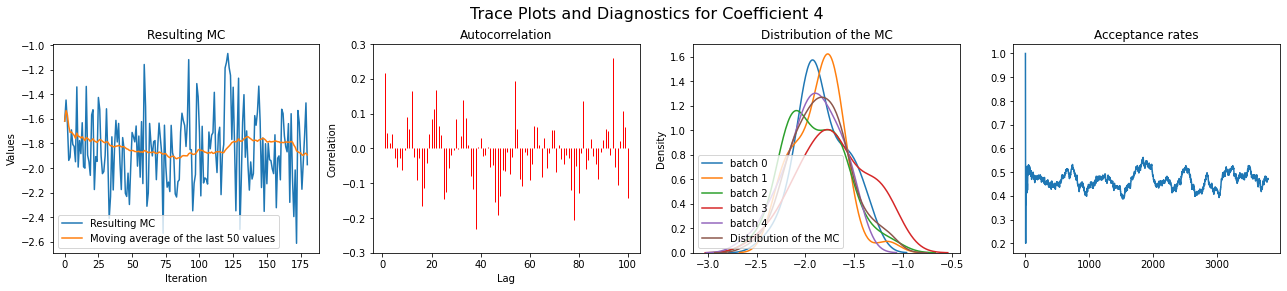

In [ ]:
# Parameters: {'b0':initial_beta_real_probit, 'prior':multivariate_normal(initial_beta_real_probit*np.ones(X_real.shape[1]), np.eye(X_real.shape[1])), 'tau':0.30}

metr_real_06 = \
run_metropolis(X_real, Y_real, T=4000, zoom_in=1000, 
              #  burnin=200, max_step=21,
               starting_beta=parameters_combinations_real_metr[5]['b0'], 
               prior=parameters_combinations_real_metr[5]['prior'], 
               tau=parameters_combinations_real_metr[5]['tau'])

#### Auxiliary Gibbs Sampler

Chosen burn-in period  for the MCMC:		100
Chosen step size to obtain i.i.d. samples:	10
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -3.00816 	Estimated standard error: 0.83783 	Estimated confidence interval: [-4.65028 -1.36604]	Significant: Yes
Coefficient 1:	Estiamted parameter: 2.3833 	Estimated standard error: 0.60344 	Estimated confidence interval: [1.20058 3.56602]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.00827 	Estimated standard error: 0.0595 	Estimated confidence interval: [-0.10835  0.12489]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00814 	Estimated standard error: 0.00922 	Estimated confidence interval: [-0.00993  0.02621]	Significant: No
Coefficient 4:	Estiamted parameter: -1.99458 	Estimated standard error: 0.32933 	Estimated confidence interval: [-2.64005 -1.34911]	Significant: Yes



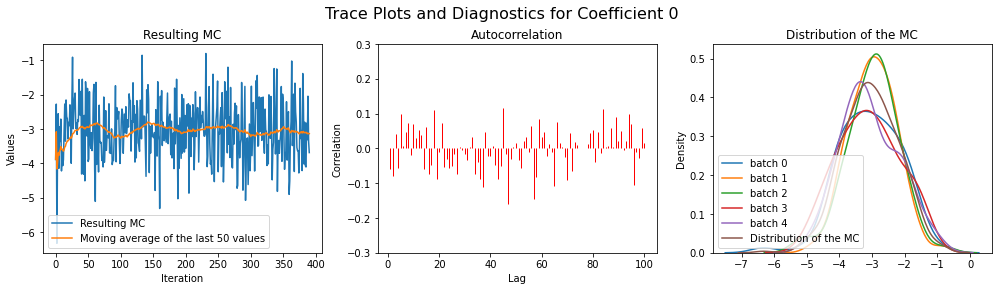

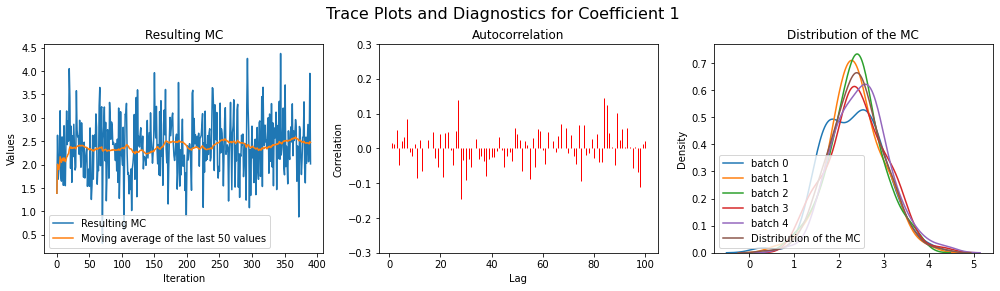

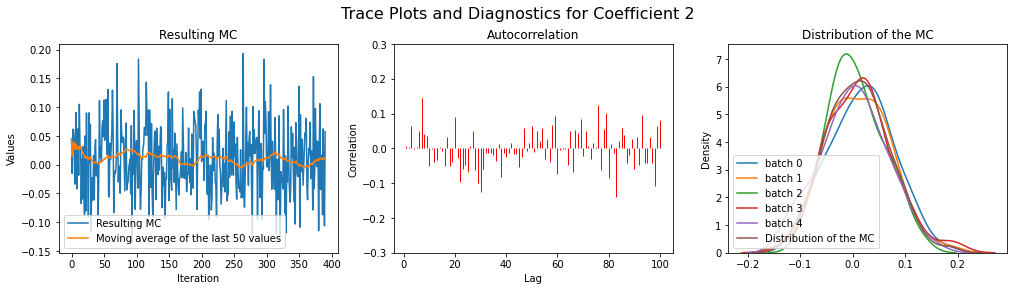

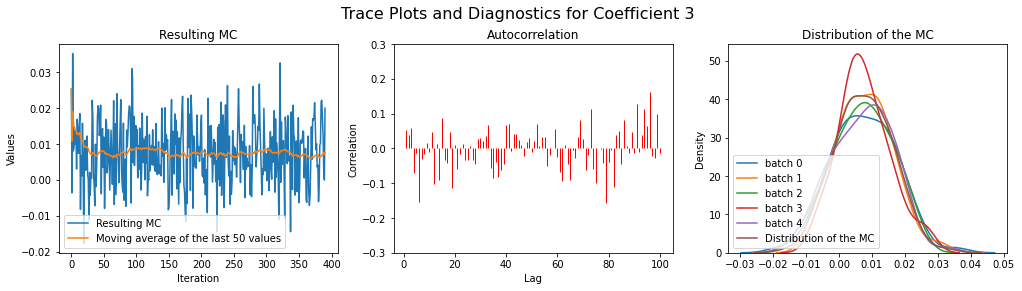

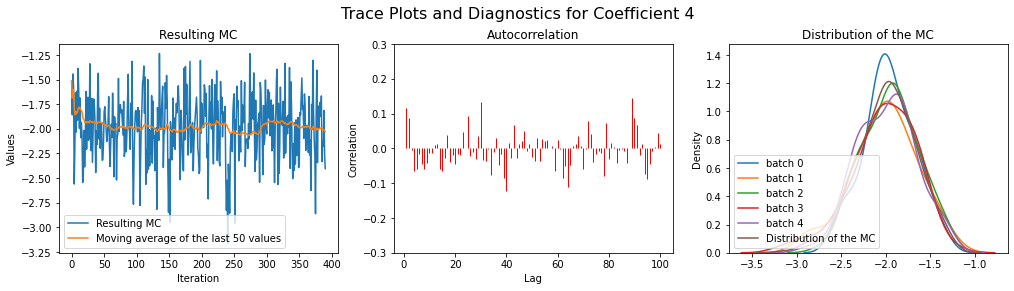

In [ ]:
# Parameters: {'b0':initial_beta_real_norm, 'prior':(initial_beta_real_norm, 5*np.eye(X_real.shape[1]))}

gibb_real_01 = \
run_aux_gibbs(X_real, Y_real, T=4000, zoom_in=300,
              #  burnin=100, max_step=10,
              starting_beta=parameters_combinations_real_gibb[0]['b0'], 
              informative_prior=parameters_combinations_real_gibb[0]['prior'])

Chosen burn-in period  for the MCMC:		150
Chosen step size to obtain i.i.d. samples:	10
Significance level for testing the estimates:	0.05


Coefficient 0:	Estiamted parameter: -3.00406 	Estimated standard error: 1.65135 	Estimated confidence interval: [-6.24065  0.23253]	Significant: No
Coefficient 1:	Estiamted parameter: 2.49273 	Estimated standard error: 0.81123 	Estimated confidence interval: [0.90275 4.08271]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.00228 	Estimated standard error: 0.07039 	Estimated confidence interval: [-0.13568  0.14024]	Significant: No
Coefficient 3:	Estiamted parameter: 0.0076 	Estimated standard error: 0.01025 	Estimated confidence interval: [-0.01249  0.02769]	Significant: No
Coefficient 4:	Estiamted parameter: -2.04297 	Estimated standard error: 0.37237 	Estimated confidence interval: [-2.7728  -1.31314]	Significant: Yes



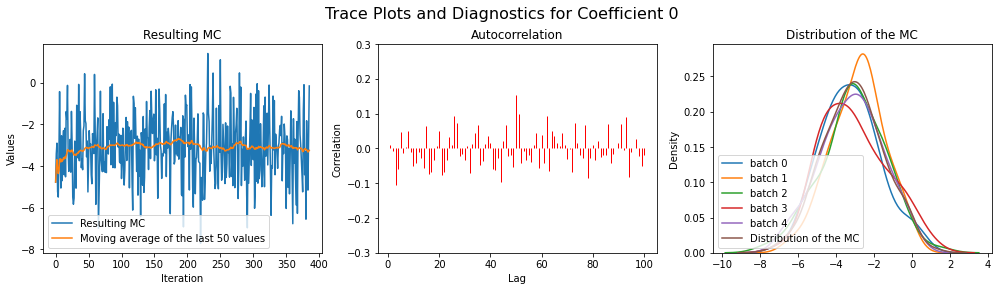

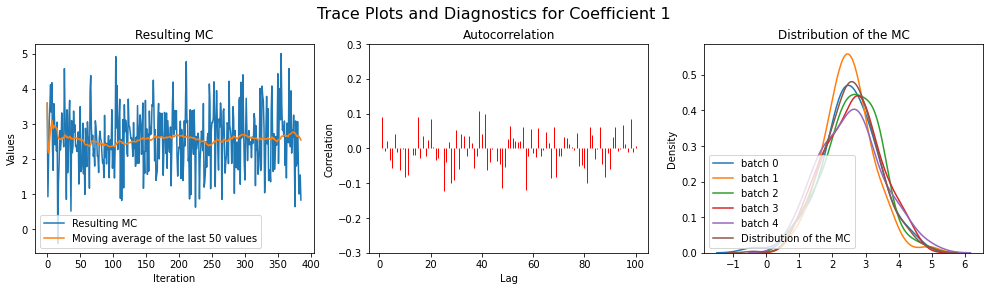

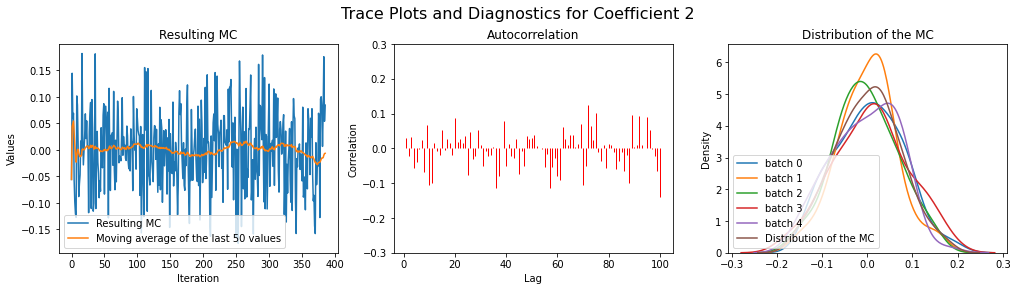

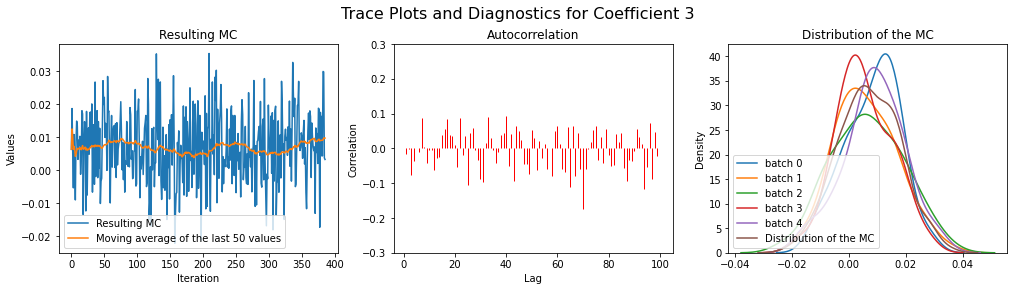

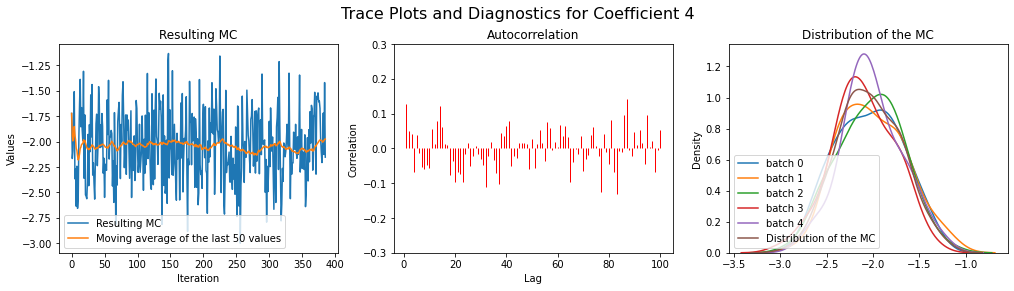

In [ ]:
# Parameters: {'b0':initial_beta_real_norm, 'prior':False}

gibb_real_02 = \
run_aux_gibbs(X_real, Y_real, T=4000, zoom_in=300, 
              #  burnin=150, max_step=10,
              starting_beta=parameters_combinations_real_gibb[1]['b0'], 
              informative_prior=parameters_combinations_real_gibb[1]['prior'])

Chosen burn-in period  for the MCMC:		50
Chosen step size to obtain i.i.d. samples:	7
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -2.91578 	Estimated standard error: 1.61338 	Estimated confidence interval: [-6.07795  0.24639]	Significant: No
Coefficient 1:	Estiamted parameter: 2.45984 	Estimated standard error: 0.78201 	Estimated confidence interval: [0.92713 3.99255]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.0035 	Estimated standard error: 0.06705 	Estimated confidence interval: [-0.12792  0.13492]	Significant: No
Coefficient 3:	Estiamted parameter: 0.0077 	Estimated standard error: 0.01048 	Estimated confidence interval: [-0.01284  0.02824]	Significant: No
Coefficient 4:	Estiamted parameter: -2.06383 	Estimated standard error: 0.3487 	Estimated confidence interval: [-2.74727 -1.38039]	Significant: Yes



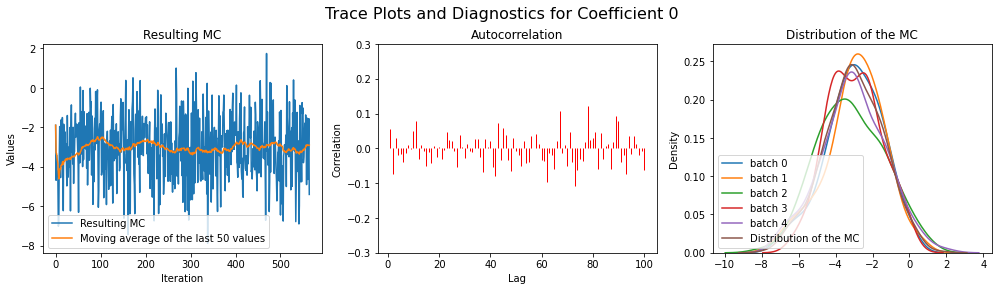

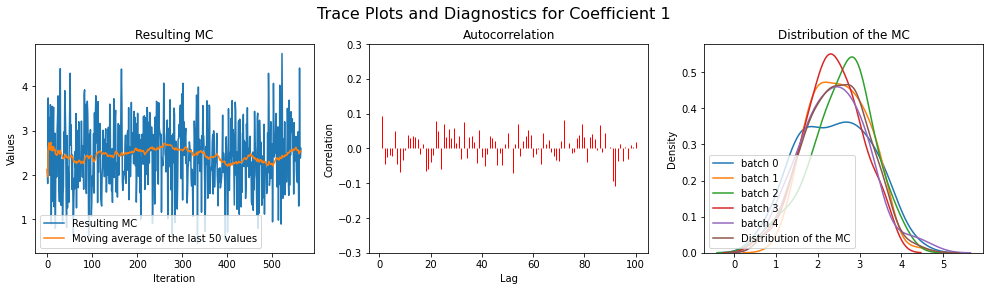

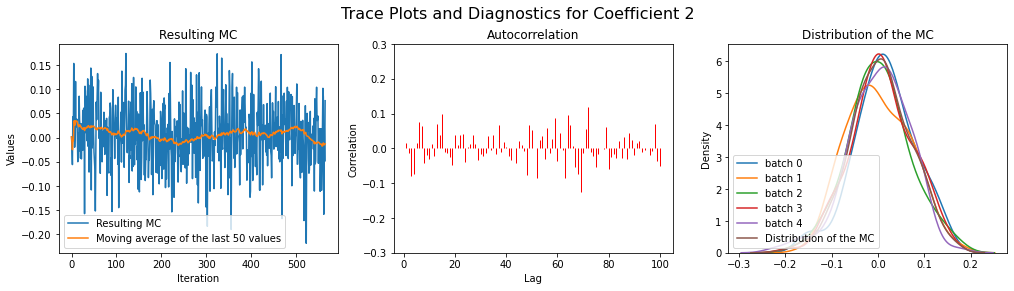

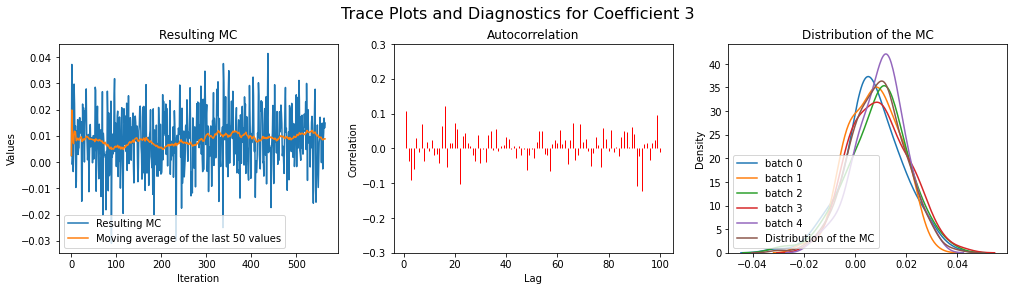

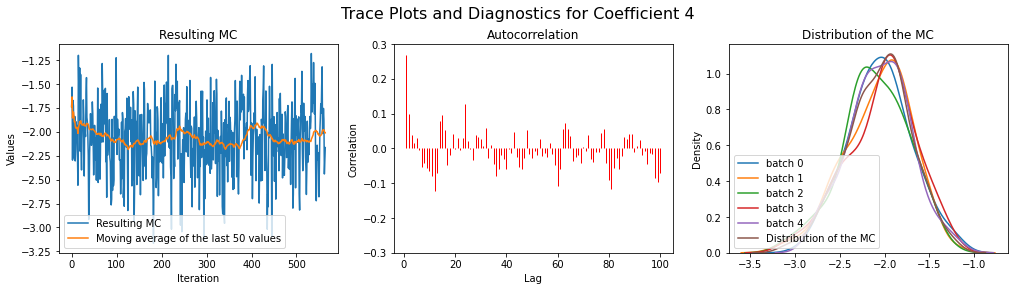

In [ ]:
# Parameters: {'b0':initial_beta_real_probit, 'prior':False}

gibb_real_03 = \
run_aux_gibbs(X_real, Y_real, T=4000, zoom_in=300,
              #  burnin=50, max_step=7,
              starting_beta=parameters_combinations_real_gibb[2]['b0'], 
              informative_prior=parameters_combinations_real_gibb[2]['prior'])

Chosen burn-in period  for the MCMC:		50
Chosen step size to obtain i.i.d. samples:	7
Significance level for testing the estimates:	0.05

No valid subsamples have been found, retrying with threshold = 0.15

Coefficient 0:	Estiamted parameter: -3.01699 	Estimated standard error: 1.27275 	Estimated confidence interval: [-5.51153 -0.52245]	Significant: Yes
Coefficient 1:	Estiamted parameter: 2.45601 	Estimated standard error: 0.741 	Estimated confidence interval: [1.00368 3.90834]	Significant: Yes
Coefficient 2:	Estiamted parameter: 0.00663 	Estimated standard error: 0.06679 	Estimated confidence interval: [-0.12428  0.13754]	Significant: No
Coefficient 3:	Estiamted parameter: 0.00797 	Estimated standard error: 0.00981 	Estimated confidence interval: [-0.01126  0.0272 ]	Significant: No
Coefficient 4:	Estiamted parameter: -2.05897 	Estimated standard error: 0.34527 	Estimated confidence interval: [-2.73569 -1.38225]	Significant: Yes



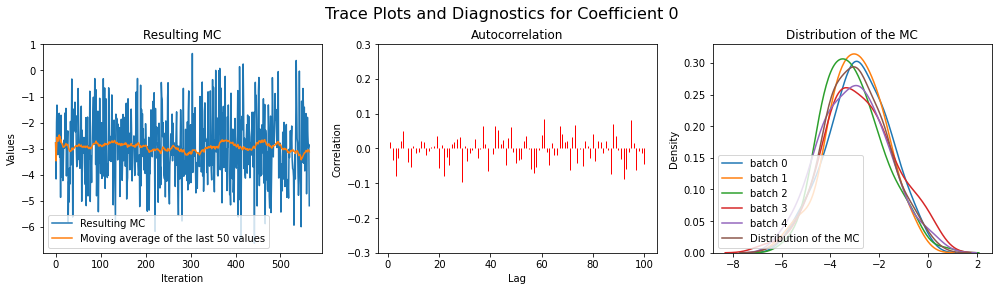

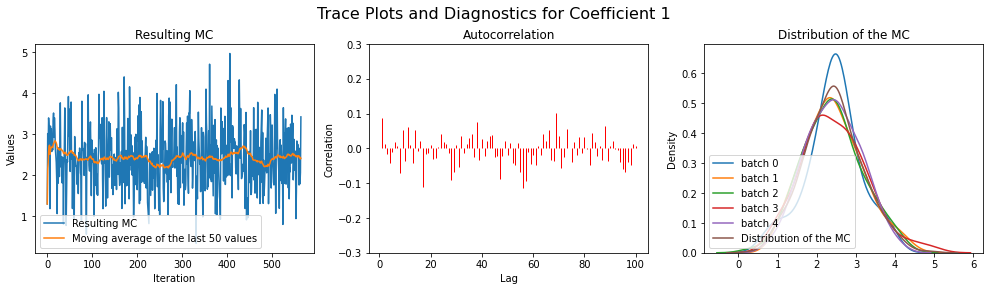

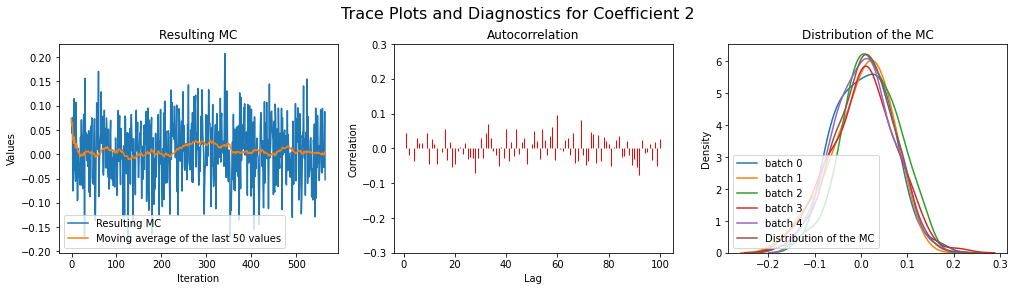

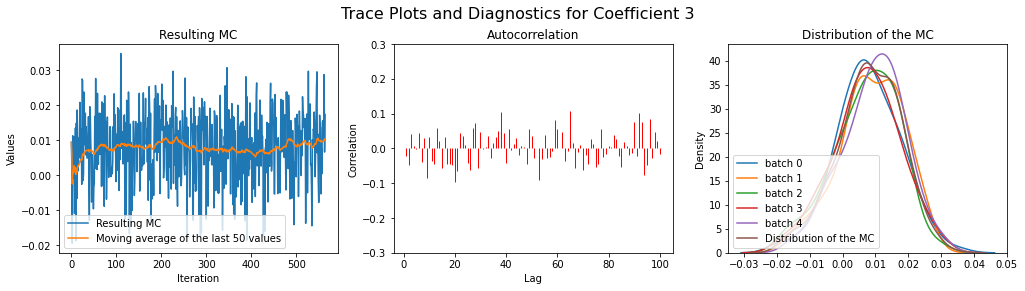

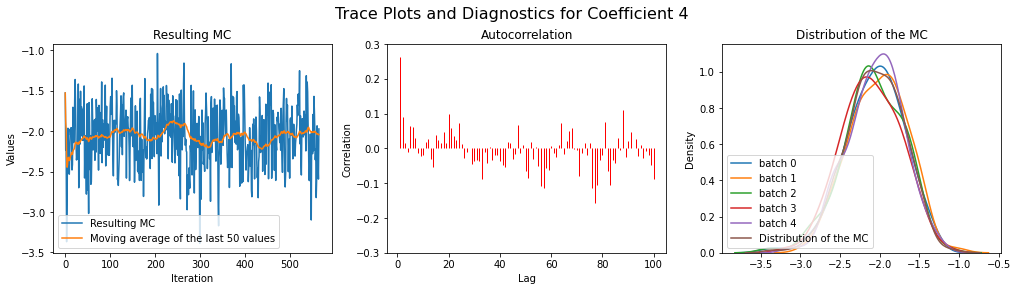

In [ ]:
# Parameters: {'b0':initial_beta_real_probit, 'prior':(initial_beta_real_probit, 5*np.eye(X_real.shape[1]))}

gibb_real_04 = \
run_aux_gibbs(X_real, Y_real, T=4000, zoom_in=300,
              #  burnin=50, max_step=7,
              starting_beta=parameters_combinations_real_gibb[3]['b0'], 
              informative_prior=parameters_combinations_real_gibb[3]['prior'])

# Models comparison and final conclusion

In [ ]:
probit_sim_00 = np.hstack((probit_sim_results.params.reshape(-1,1), probit_sim_results.bse.reshape(-1,1))).round(5)
probit_real_00 = np.hstack((probit_real_results.params.reshape(-1,1), probit_real_results.bse.reshape(-1,1))).round(5)


params_metr = np.array((['MLE Estimates','N(0, 4)','N(0, 4)','b_MLE','b_MLE','b_MLE','b_MLE'], 
                        ['NA','N(b_0, 1)','non informative','non informative','N(b_0, 1)','N(b_0, 5)','N(b_0, 1)'], 
                        ['NA',0.45,0.45,0.45,0.45,0.45,0.30])).T

params_gibb = np.array((['MLE_Estimates','N(0, 4)','N(0, 4)','b_MLE','b_MLE'], 
                        ['NA','N(b_0, 1)','non informative','non informative','N(b_0, 5)'])).T 


sim_metr = pd.DataFrame(np.hstack((params_metr, np.vstack((probit_sim_00, metr_sim_01,metr_sim_02,metr_sim_03,metr_sim_04,metr_sim_05,metr_sim_06)).reshape(7,-1))))
sim_gibb = pd.DataFrame(np.hstack((params_gibb, np.vstack((probit_sim_00, gibb_sim_01,gibb_sim_02,gibb_sim_03,gibb_sim_04)).reshape(5,-1))))
real_metr = pd.DataFrame(np.hstack((params_metr, np.vstack((probit_real_00, metr_real_01,metr_real_02,metr_real_03,metr_real_04,metr_real_05,metr_real_06)).reshape(7,-1))))
real_gibb = pd.DataFrame(np.hstack((params_gibb, np.vstack((probit_real_00, gibb_real_01,gibb_real_02,gibb_real_03,gibb_real_04)).reshape(5,-1))))

sim_metr.columns = ['Starting Beta', 'Prior', 'Tau'] + sum([[f'Beta_{i}', f'StdErr_{i}'] for i in range(X_sim.shape[1])], [])
real_metr.columns = ['Starting Beta', 'Prior', 'Tau'] + sum([[f'Beta_{i}', f'StdErr_{i}'] for i in range(X_real.shape[1])], [])
sim_gibb.columns = ['Starting Beta', 'Prior'] + sum([[f'Beta_{i}', f'StdErr_{i}'] for i in range(X_sim.shape[1])], [])
real_gibb.columns = ['Starting Beta', 'Prior'] + sum([[f'Beta_{i}', f'StdErr_{i}'] for i in range(X_real.shape[1])], [])

In [ ]:
sim_metr

Starting Beta            Prior   Tau  ... StdErr_1   Beta_2 StdErr_2
0  MLE Estimates               NA    NA  ...  0.54245  1.04433  0.30675
1        N(0, 4)        N(b_0, 1)  0.45  ...  0.27501   0.7443  0.21043
2        N(0, 4)  non informative  0.45  ...  0.49355  1.01008  0.29424
3          b_MLE  non informative  0.45  ...  0.52074  0.99011  0.28949
4          b_MLE        N(b_0, 1)  0.45  ...  0.41443  1.01046  0.25725
5          b_MLE        N(b_0, 5)  0.45  ...   0.5093  0.99054  0.29815
6          b_MLE        N(b_0, 1)   0.3  ...  0.44225  1.00309  0.27083

[7 rows x 9 columns]

In [ ]:
real_metr

Starting Beta            Prior   Tau  ... StdErr_3    Beta_4 StdErr_4
0  MLE Estimates               NA    NA  ...  0.01027  -1.94575  0.35727
1        N(0, 4)        N(b_0, 1)  0.45  ...  0.00841  -1.91254  0.32908
2        N(0, 4)  non informative  0.45  ...  0.00954  -1.87564  0.32853
3          b_MLE  non informative  0.45  ...  0.00982  -1.83528  0.35147
4          b_MLE        N(b_0, 1)  0.45  ...  0.00937  -1.90765  0.31192
5          b_MLE        N(b_0, 5)  0.45  ...  0.00951  -1.88203  0.35581
6          b_MLE        N(b_0, 1)   0.3  ...  0.00837   -1.8328  0.30976

[7 rows x 13 columns]

In [ ]:
sim_gibb

Starting Beta            Prior    Beta_0  ... StdErr_1   Beta_2 StdErr_2
0  MLE_Estimates               NA   -0.1682  ...  0.54245  1.04433  0.30675
1        N(0, 4)        N(b_0, 1)  -0.00955  ...  0.33437   0.8316  0.23819
2        N(0, 4)  non informative  -0.16916  ...  0.51715  1.09311  0.31431
3          b_MLE  non informative   -0.1797  ...  0.49587  1.11175  0.30446
4          b_MLE        N(b_0, 5)  -0.18764  ...   0.5461  1.12808  0.30902

[5 rows x 8 columns]

In [ ]:
real_gibb

Starting Beta            Prior    Beta_0  ... StdErr_3    Beta_4 StdErr_4
0  MLE_Estimates               NA  -3.00769  ...  0.01027  -1.94575  0.35727
1        N(0, 4)        N(b_0, 1)  -3.00816  ...  0.00922  -1.99458  0.32933
2        N(0, 4)  non informative  -3.00406  ...  0.01025  -2.04297  0.37237
3          b_MLE  non informative  -2.91578  ...  0.01048  -2.06383   0.3487
4          b_MLE        N(b_0, 5)  -3.01699  ...  0.00981  -2.05897  0.34527

[5 rows x 12 columns]

In [ ]:
sim_metr.to_excel('Metropolis-simulated_data.xlsx', index=False)
real_metr.to_excel('Metropolis-real_data.xlsx', index=False)
sim_gibb.to_excel('AuxGibbs-simulated_data.xlsx', index=False)
real_gibb.to_excel('AuxGibbs-real_data.xlsx', index=False)
